In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

[ruth-macbook.local:30413] shmem: mmap: an error occurred while determining whether or not /var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T//ompi.ruth-macbook.503/jf.0/1397227520/sm_segment.ruth-macbook.503.53480000.0 could be created.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rcParams.update({'font.size': 18})


Here I'm going to stick with the axisymmetric case (again to test the procedure) but expand the spectral method to 2D. I won't explicitly assume separability of $r$ and $\theta$ but if I define my bathymetry to be symmetric it *should* still give the same answer.

Now we are assuming solutions of the form,

$$\Psi(r,\theta,t) = \Re\Big\{ \Phi(r,\theta)\, e^{-2i\omega\Omega t}\Big\}$$

(i.e. we do not assume separability of $r$ and $\theta$) to the Topographic Rossby Wave Equation for linear barotropic CSWs. This means the problem we are solving is,

$$\frac{1}{H}\nabla^2\Phi + \nabla\Big(\frac{1}{H}\Big)\cdot \nabla \Phi +\frac{i}{\omega}\boldsymbol{\hat{k}}\cdot\Big(\nabla \Phi \times \nabla\Big(\frac{1}{H}\Big)\Big)=0$$

over the domain $r\in(a,1)$, $\theta\in (0,2\pi)$ subject to the boundary conditions 
$$\Phi(r=a, \theta) = 0$$
and a Dirichlet-to_Neumann BC at the outer boundary.
 Note here that $\Psi$ and $H$ are (nominally, in this contrived example where the symmetry is retained but we expand to 2D) functions of both $r$ and $\theta$.
 
 
 We will take Chebyshev points for the $r$ axis and Fourier points for the $\theta$ axis (note - no additional BCs needed here). Defining the basis this way (as opposed to an annulus basis) means I will need to expand the vector calculus notation above but it avoids the issue of having to wait for a 2D implementation of `cross` in Dedalus (i.e. $\boldsymbol{\hat{k}}\cdot(\boldsymbol{a}\times \boldsymbol{b})$ where $\boldsymbol{a}$ and $\boldsymbol{b}$ are 2D, this currently doesnt work). There may be *some* performence reduction on account of all the $r^{-1}$ geometric terms that the coordinate transfer introduces (these aren't great on Chebyshev) but it should probably be okay.


We'll need to include tau terms again and I'm going to start off with a simple second order expression,

$$\underbrace{\frac{1}{H} \Big(\partial_{rr}\Phi +\frac{1}{r}\partial_{r}\Phi + \frac{1}{r^2}\partial_{\theta\theta}\Phi\Big)}_{\frac{1}{H}\nabla^2\Phi}+    \underbrace{\partial_r\Phi \partial_r \big(\frac{1}{H}\big)+\frac{1}{r^2}\partial_\theta\Phi \partial_\theta \big(\frac{1}{H}\big)}_{\nabla(\frac{1}{H})\cdot \nabla \Phi}+
\underbrace{\frac{i}{r \omega}\Big(\partial_r\Phi \partial_\theta\big(\frac{1}{H}\big)-\partial_\theta\Phi \partial_r\big(\frac{1}{H}\big)   \Big)}_{\frac{i}{\omega}\boldsymbol{\hat{k}}\cdot(\nabla \Phi \times \nabla(\frac{1}{H}))}+\tau_1 V_{n-1}+\tau_2  V_{n-2}=0.$$



There were some complications with the initial implementation of the above on accound of incorrect BCs. I will make notes on this on the iPad but essentially I misunderstood how to implement the Dirichlet-to-Neumann BC at the annulus edge and was imposing a BC of the same order (second order differential equation BC to second order differential equation...). So more thought is needed re the implementation of the outer BC.


There are two options I can see:

1) Firstly, we could keep the Dirichlet-to-Neumann BC and translate it to an appropriate form. This is a bit beyond me but requires the use of Hilbert spaces or something. Anyway, Keaton has coded up something that will hopefully work.

2) Secondly we could just expand the domain and impose a more simple BC of setting the pressure field to zero in the far field of the flat bathymetry area. (**Update: I looked into this and it isn't feasible. The $\Phi$ terms associated with low azimuthal wavenumbers decay very slowly away from the island and so for these to equate 0 at the boundary the length of the domain in $r$ would need to be unfeasibly large, else the low modes would be removed from the solution**)

As note above, turns out we'll need the D-to-N BC even if we expand the domain size, but as a transition to the full problem I have the expanded the domain past the shelf edge in part 2 of this notebook.

### Dirichlet

To modify from the dirichlet condition the only edits here were to comment out the lines commented below and add the different outer BC.

In [4]:
Ri, Ro, Rb = 0.5, 6, 1 #note - Ri (inner radius) is 'a' from previous
Nθ, Nr = 64, 64 #resolution
α = 1 #bathymetry parameter
dtype = np.complex128

coords  = d3.CartesianCoordinates('θ', 'r')
dist    = d3.Distributor(coords, dtype=dtype)
θ_basis = d3.Fourier(coords['θ'], Nθ, (0, 2*np.pi), dtype=dtype)
r_basis = d3.Chebyshev(coords['r'], Nr, (Ri, Ro))
# Fields
Φ    = dist.Field(name='Φ', bases=(θ_basis, r_basis))
tau1 = dist.Field(name='tau1', bases=θ_basis)
tau2 = dist.Field(name='tau2', bases=θ_basis)
ωinv = dist.Field(name='ωinv')
# Substitutions
dθ = lambda A: d3.Differentiate(A, coords['θ'])
dr = lambda A: d3.Differentiate(A, coords['r'])
θ, r = dist.local_grids(θ_basis, r_basis)
rinv = dist.Field(bases=r_basis)
rinv['g'] = r**(-1)
Hinv = dist.Field(bases=r_basis) 
Hinv['g'] = r**(-2*α)
Hinv['g'][r>Rb] = 1
lift_basis = r_basis.derivative_basis(2)
tau_terms = d3.Lift(tau1, lift_basis, -1) + d3.Lift(tau2, lift_basis, -2)
# m_func = lambda m: abs(m)
# abs_m = lambda A: abs_m_cls(A, coords['θ']) #note this implements the Dirichlet-to-Neumann BC

# Problem
problem = d3.EVP([Φ, tau1, tau2], eigenvalue=ωinv, namespace=locals())
problem.add_equation("Hinv*(dr(dr(Φ)) + rinv*dr(Φ) + rinv**2*dθ(dθ(Φ))) + dr(Φ)*dr(Hinv) + rinv**2*dθ(Φ)*dθ(Hinv) + 1j*rinv*ωinv*(dr(Φ)*dθ(Hinv) - dθ(Φ)*dr(Hinv)) + tau_terms = 0 ")
problem.add_equation("Φ(r=Ri)=0") #inner BC
problem.add_equation("Φ(r=Ro)=0") #inner BC
# problem.add_equation("dr(Φ)(r=Ro) + abs_m(Φ)(r=Ro) / Ro = 0") #outer BC

{'LHS': interp(<Field 5261515264>, r=6),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'M': 0,
 'L': interp(<Field 5261515264>, r=6),
 'domain': <dedalus.core.domain.Domain at 0x136b3dc10>,
 'matrix_dependence': array([False,  True]),
 'matrix_coupling': array([False,  True])}

### Separable Problem (subproblems)

In [5]:
sub = 2

In [6]:
# Solve (individual separable modes...)
solver_uncoupled = problem.build_solver()
solver_uncoupled.solve_dense(solver_uncoupled.subproblems[sub]) 

2024-08-07 17:29:05,772 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 5s, Remaining: 0s, Rate: 2.2e-01/s


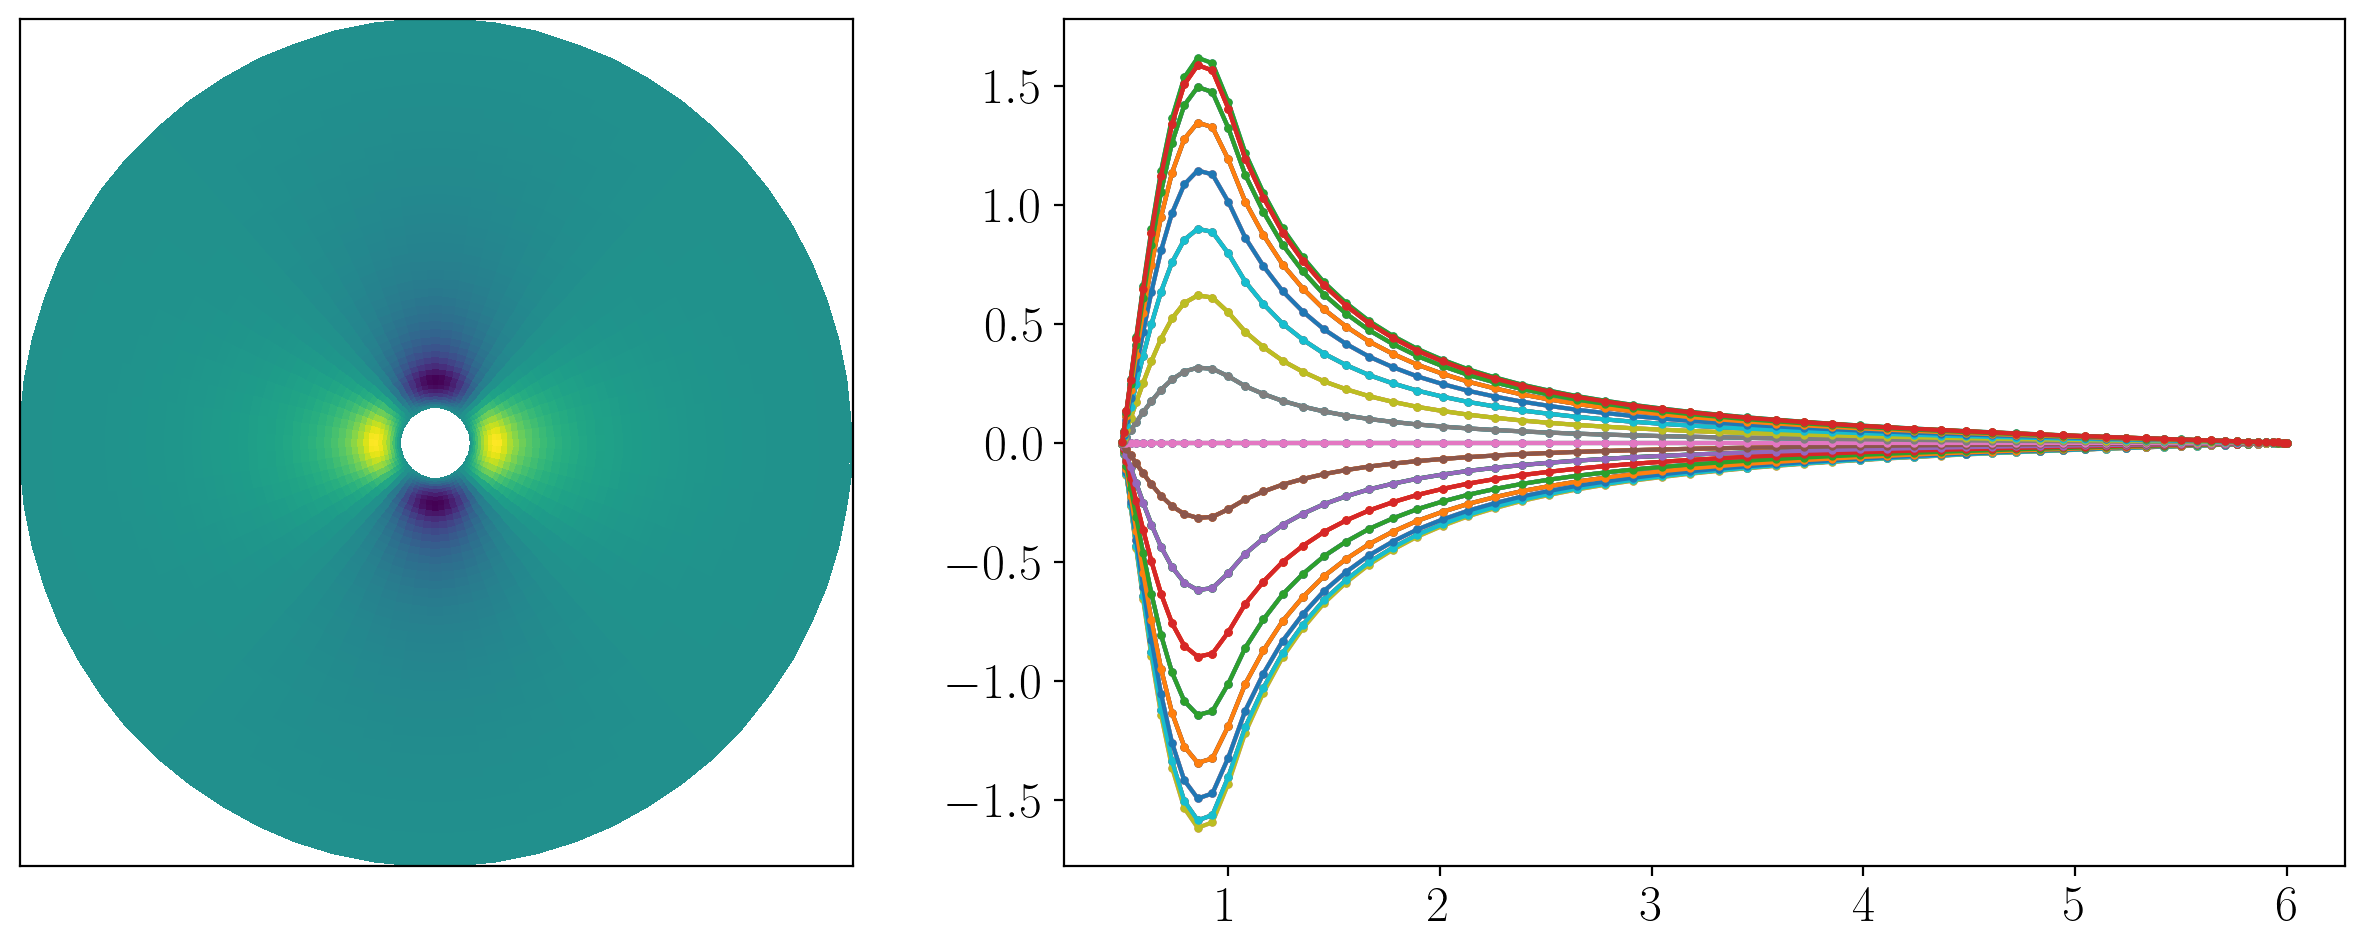

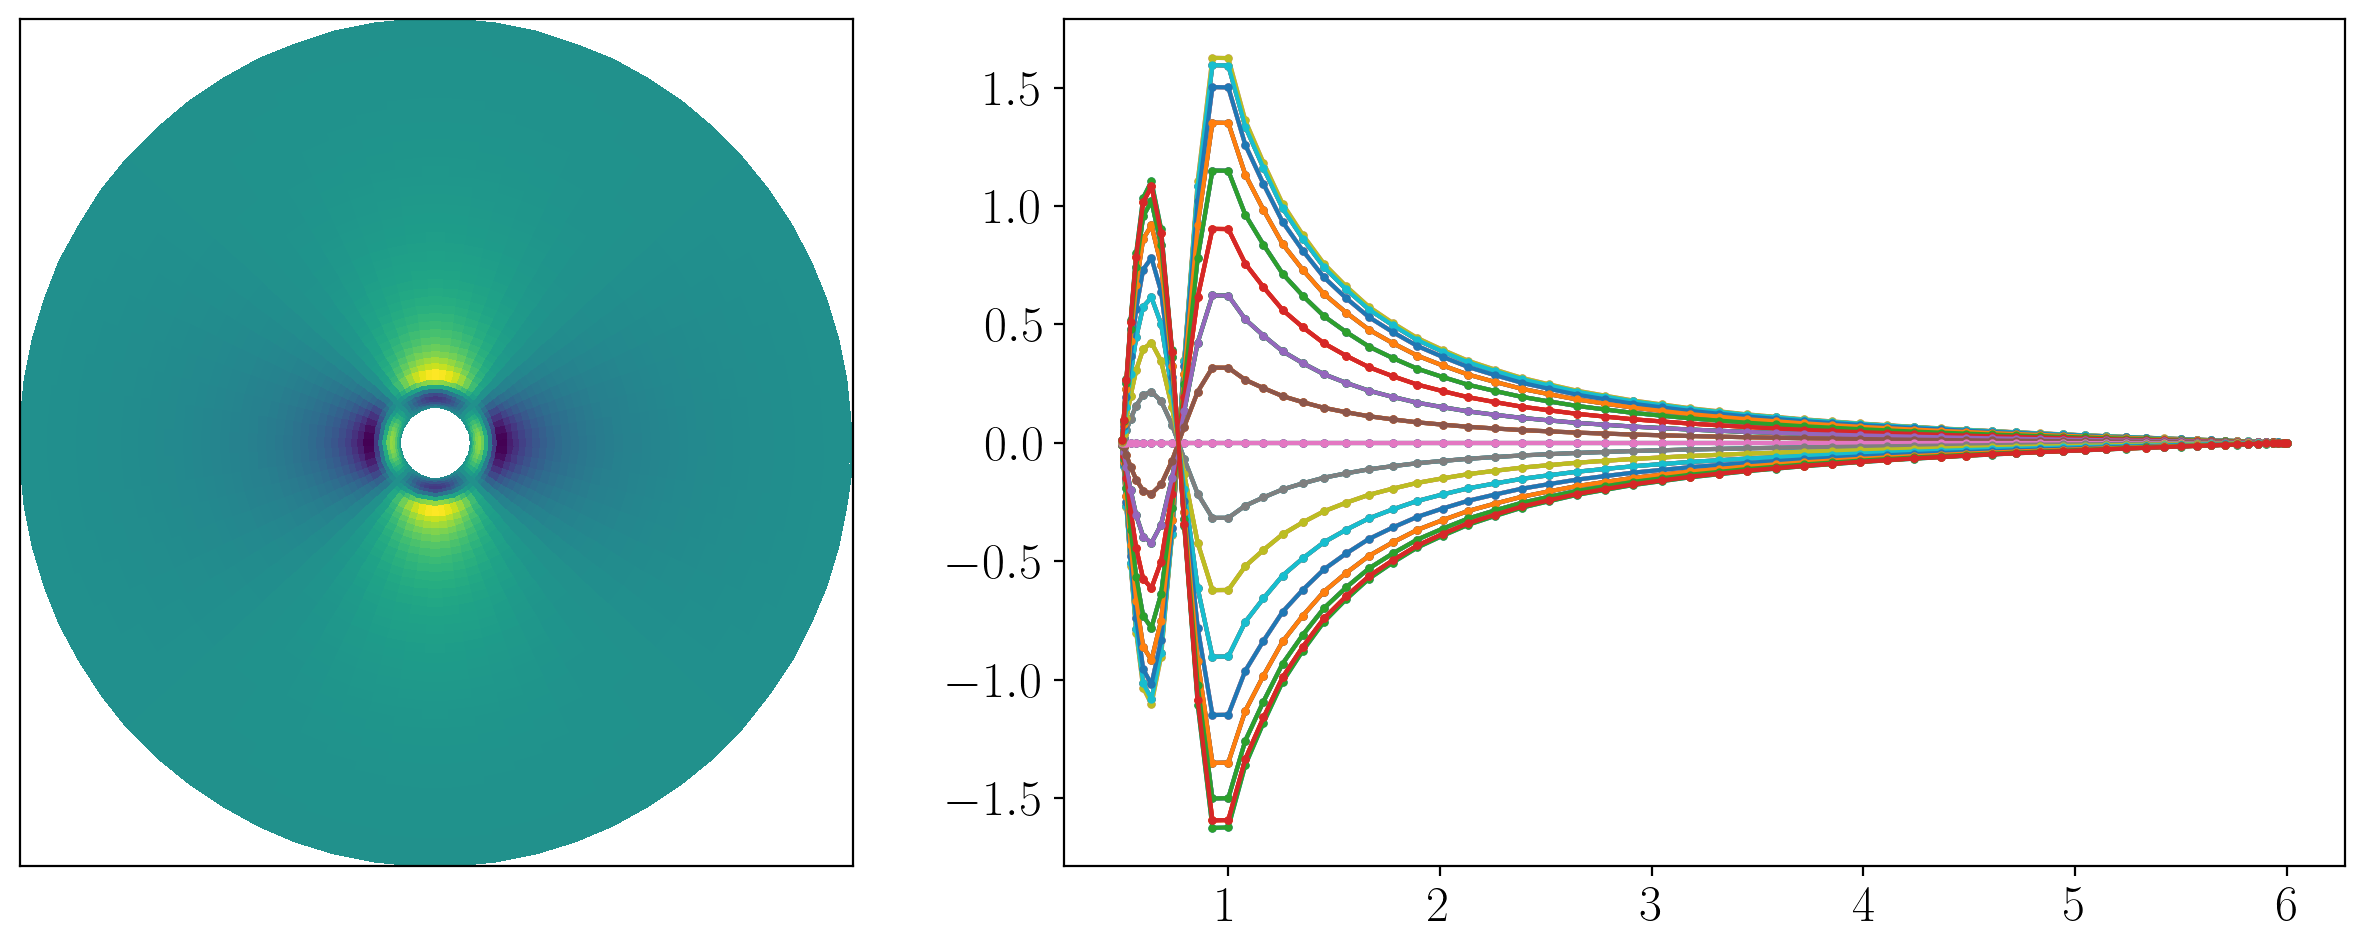

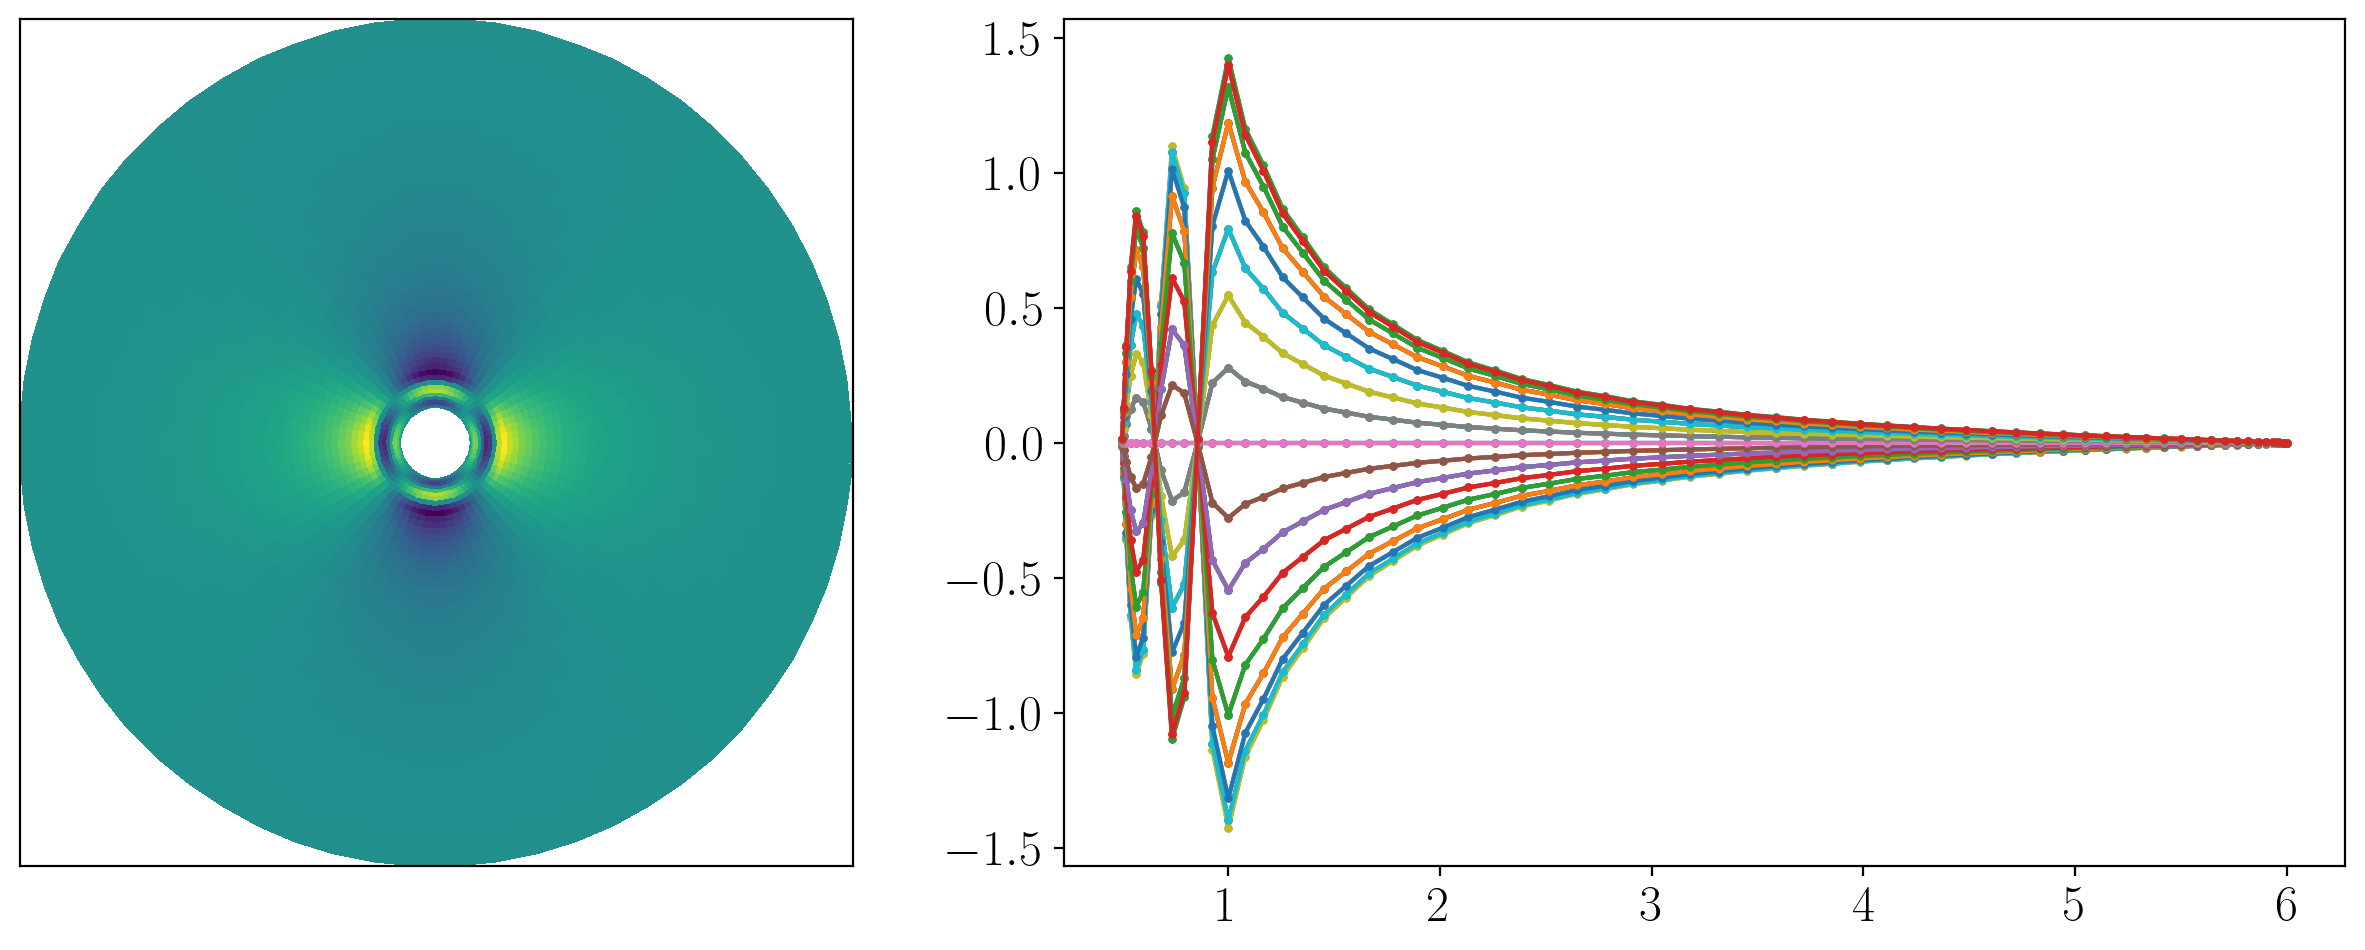

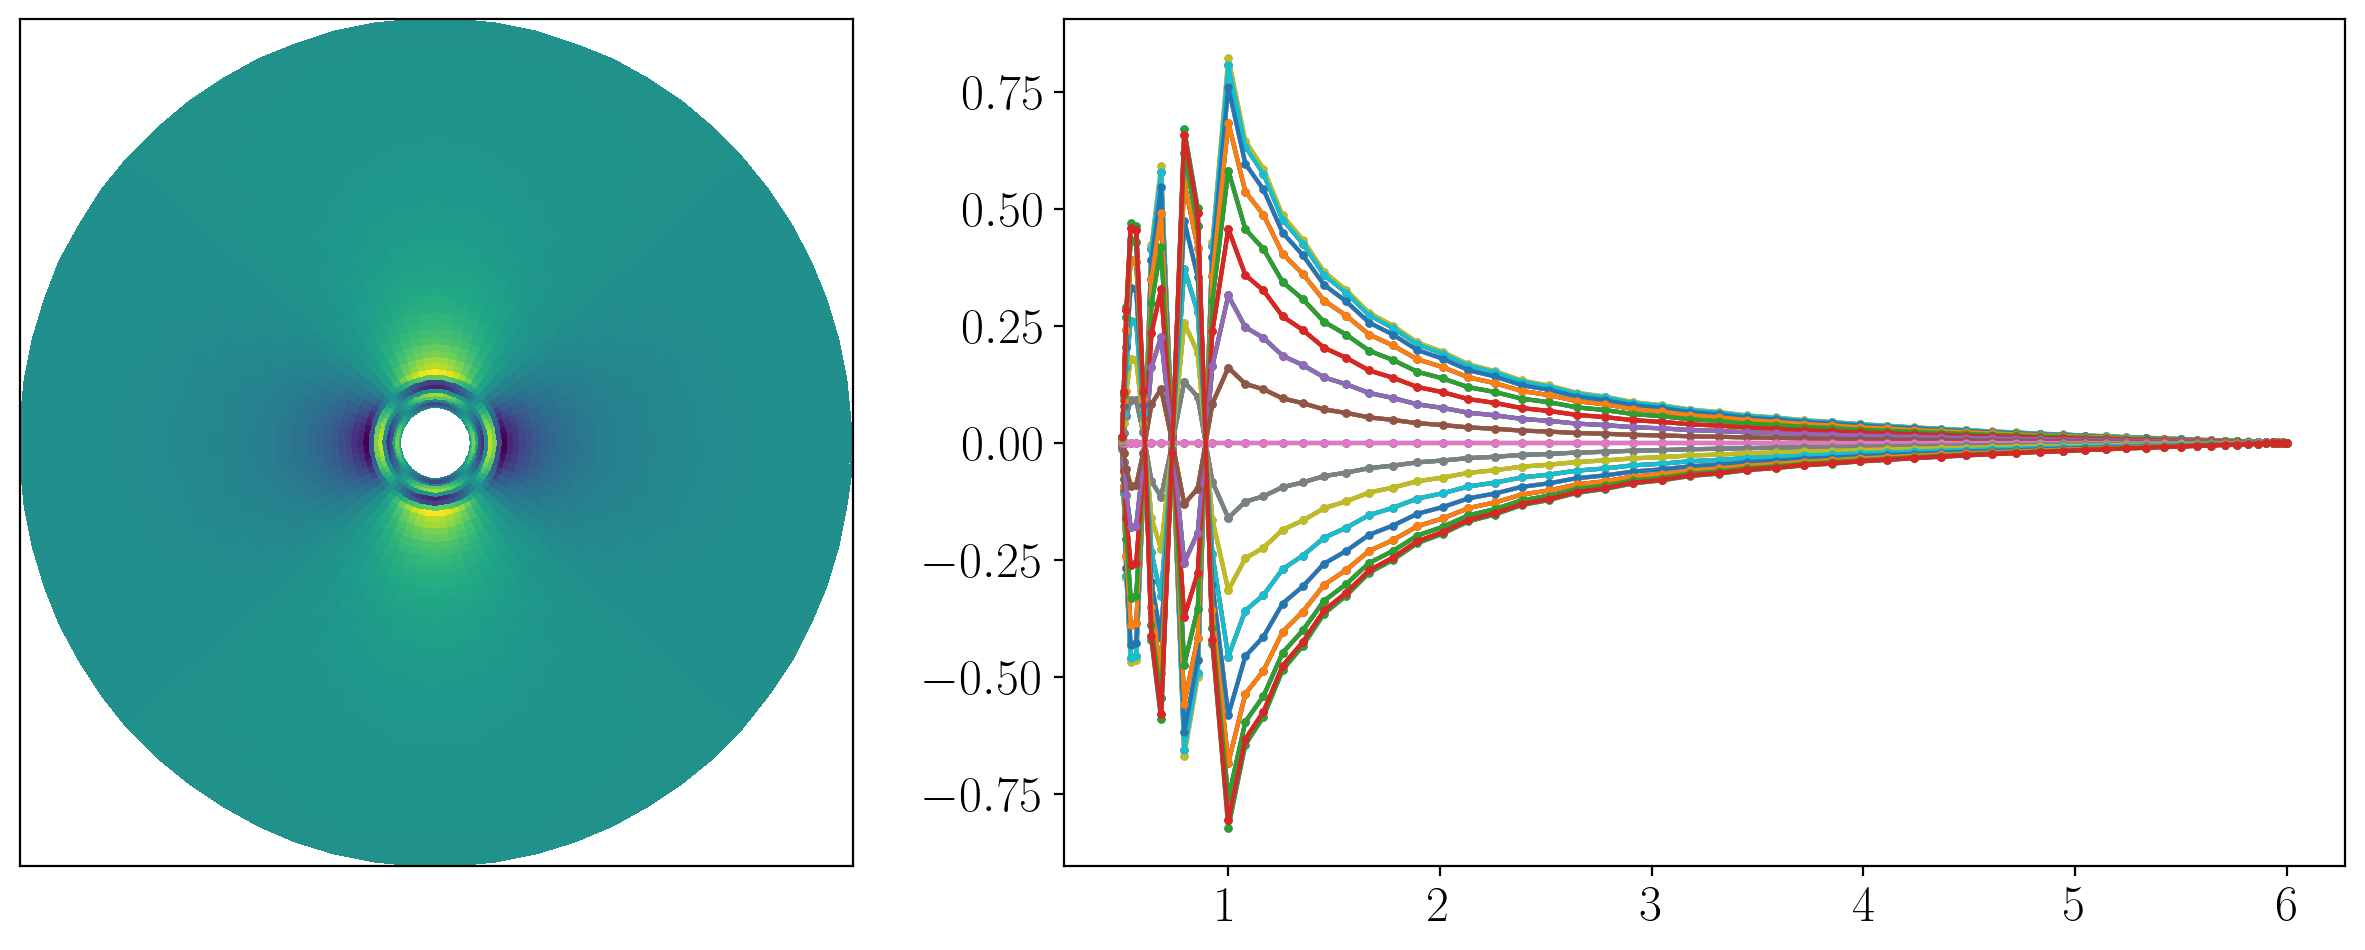

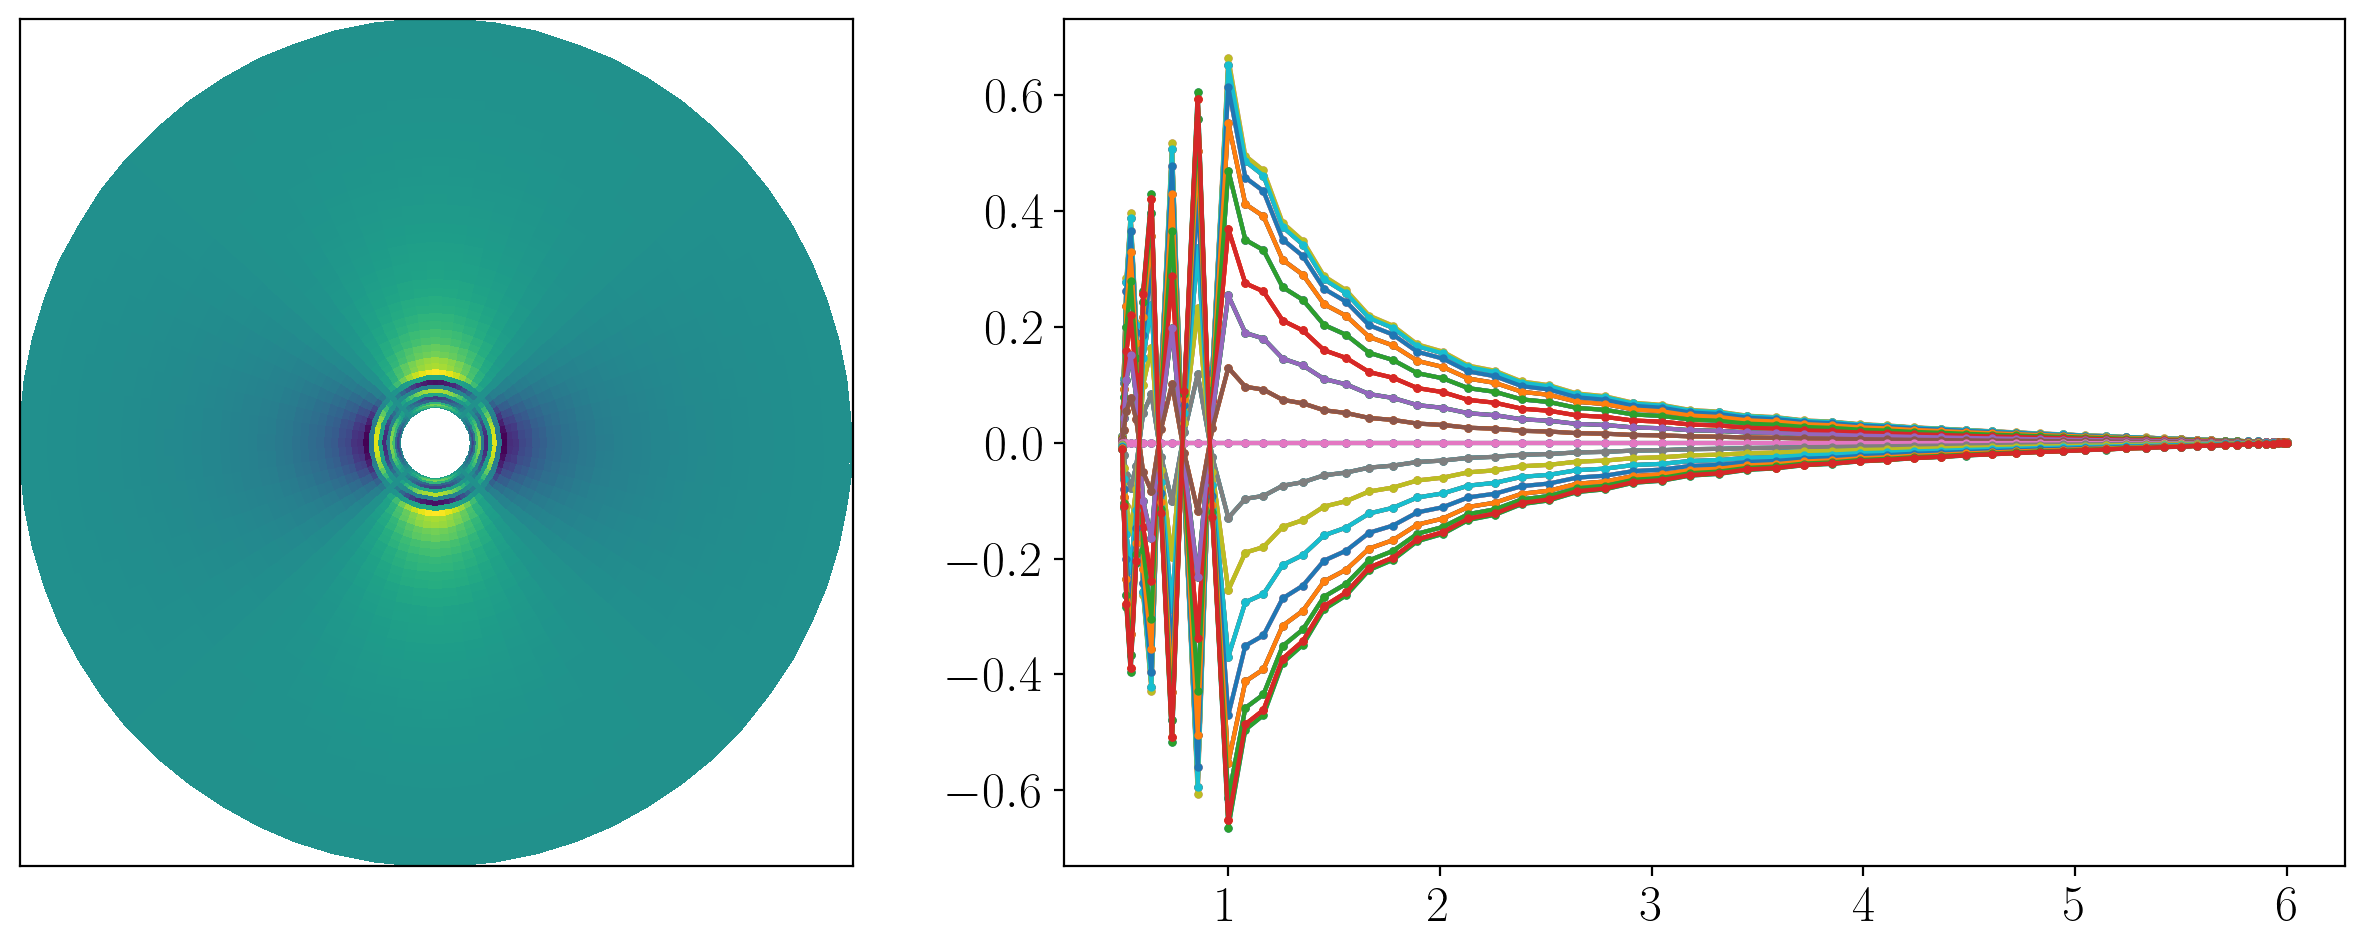

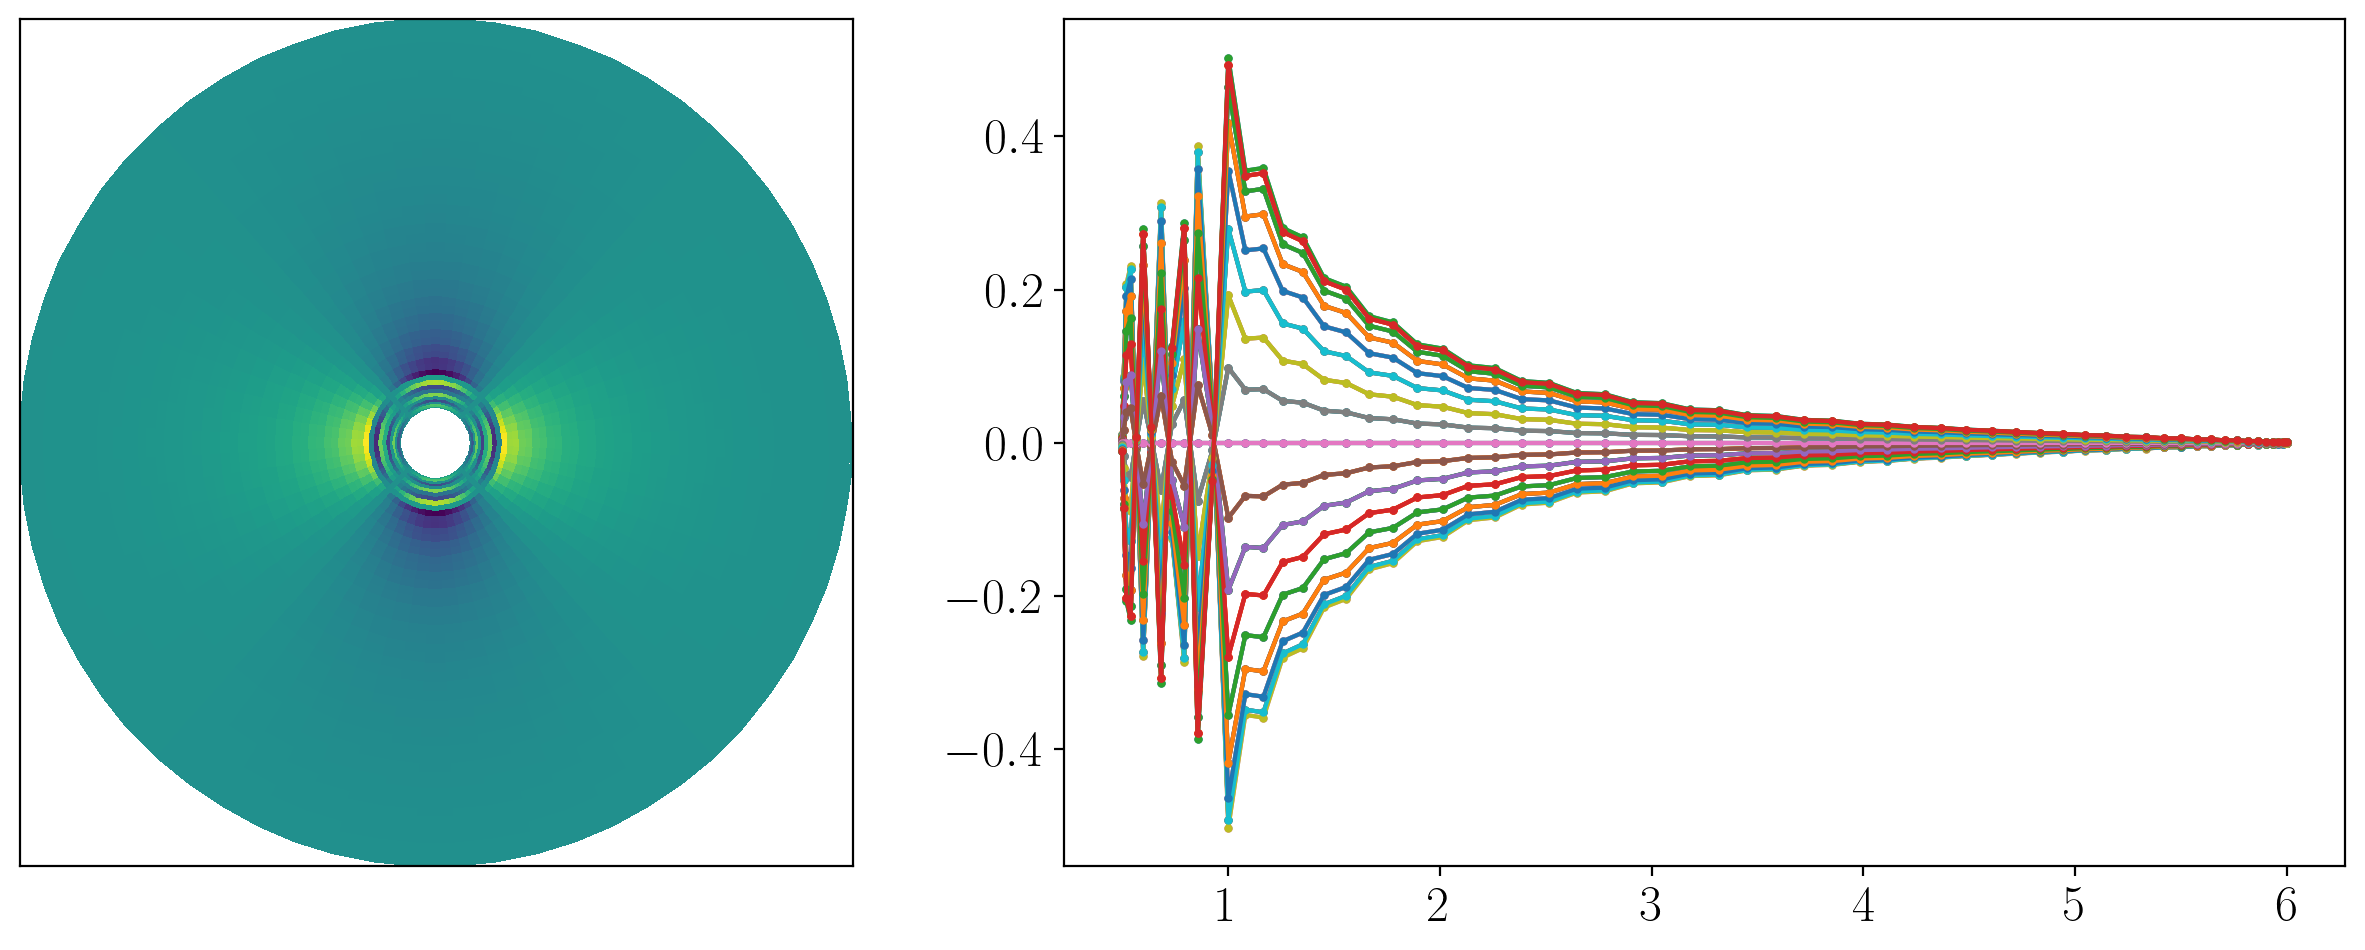

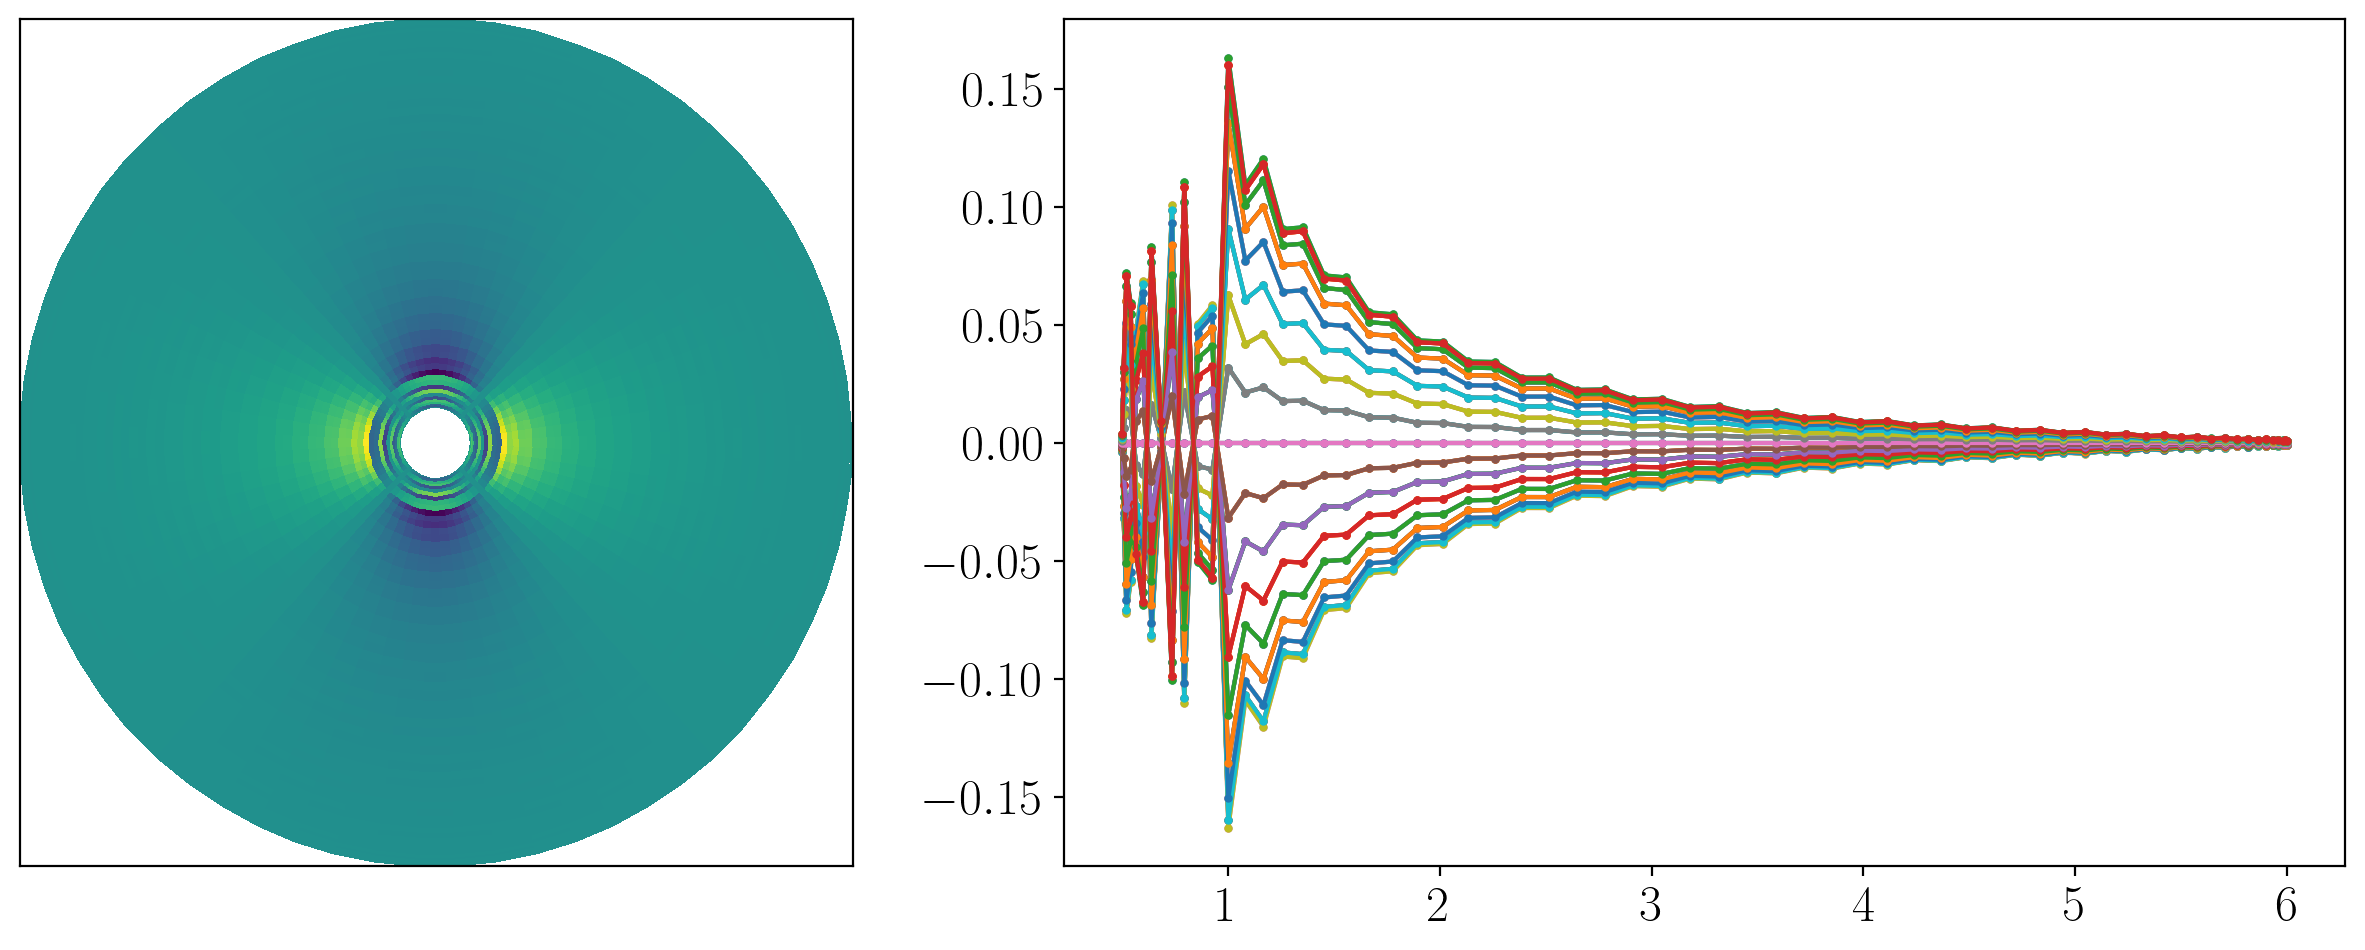

In [8]:
mode_order = np.argsort((np.real(1/solver_uncoupled.eigenvalues)))
eigs_order = np.abs(np.sort((np.real(1/solver_uncoupled.eigenvalues))))
### plot coupled system solution
R,THETA = np.meshgrid(r,θ)
x = R*np.cos(THETA); y=R*np.sin(THETA)

for i in mode_order[:7]:
    fig,(ax,ax1) = plt.subplots(1,2, figsize=(15,5.5),gridspec_kw={'width_ratios': [1.3,2]})
    solver_uncoupled.set_state(i, solver_uncoupled.subsystems[sub])
    ax.pcolormesh(x,y,(Φ['g'].real))
    for j in range(Nθ):
        ax1.plot(np.squeeze(r),np.real(Φ['g'])[j,:], marker='o', markersize=2)
    ax.set_xticks([]);ax.set_yticks([])
    plt.show()

Get's a little messy the larger the radial wavenumber, but, again, that makes sense...

### Coupled Problem

In [9]:
%%time
## takes like 10 min
solver_coupled = problem.build_solver(matrix_coupling=(True,True))
solver_coupled.solve_dense(solver_coupled.subproblems[0])

2024-08-07 17:33:10,835 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s
CPU times: user 10min 30s, sys: 4.56 s, total: 10min 34s
Wall time: 10min 32s


In [10]:
frequencies = np.abs(np.sort((np.real(1/solver_coupled.eigenvalues))))
frequencies[:20]

array([0.27089817, 0.26624551, 0.25145007, 0.24974728, 0.23365972,
       0.21591484, 0.19939524, 0.18446397, 0.17170015, 0.17113773,
       0.1592971 , 0.14877948, 0.13941913, 0.13106316, 0.12493532,
       0.12485694, 0.1235767 , 0.12320289, 0.12268012, 0.12052828])

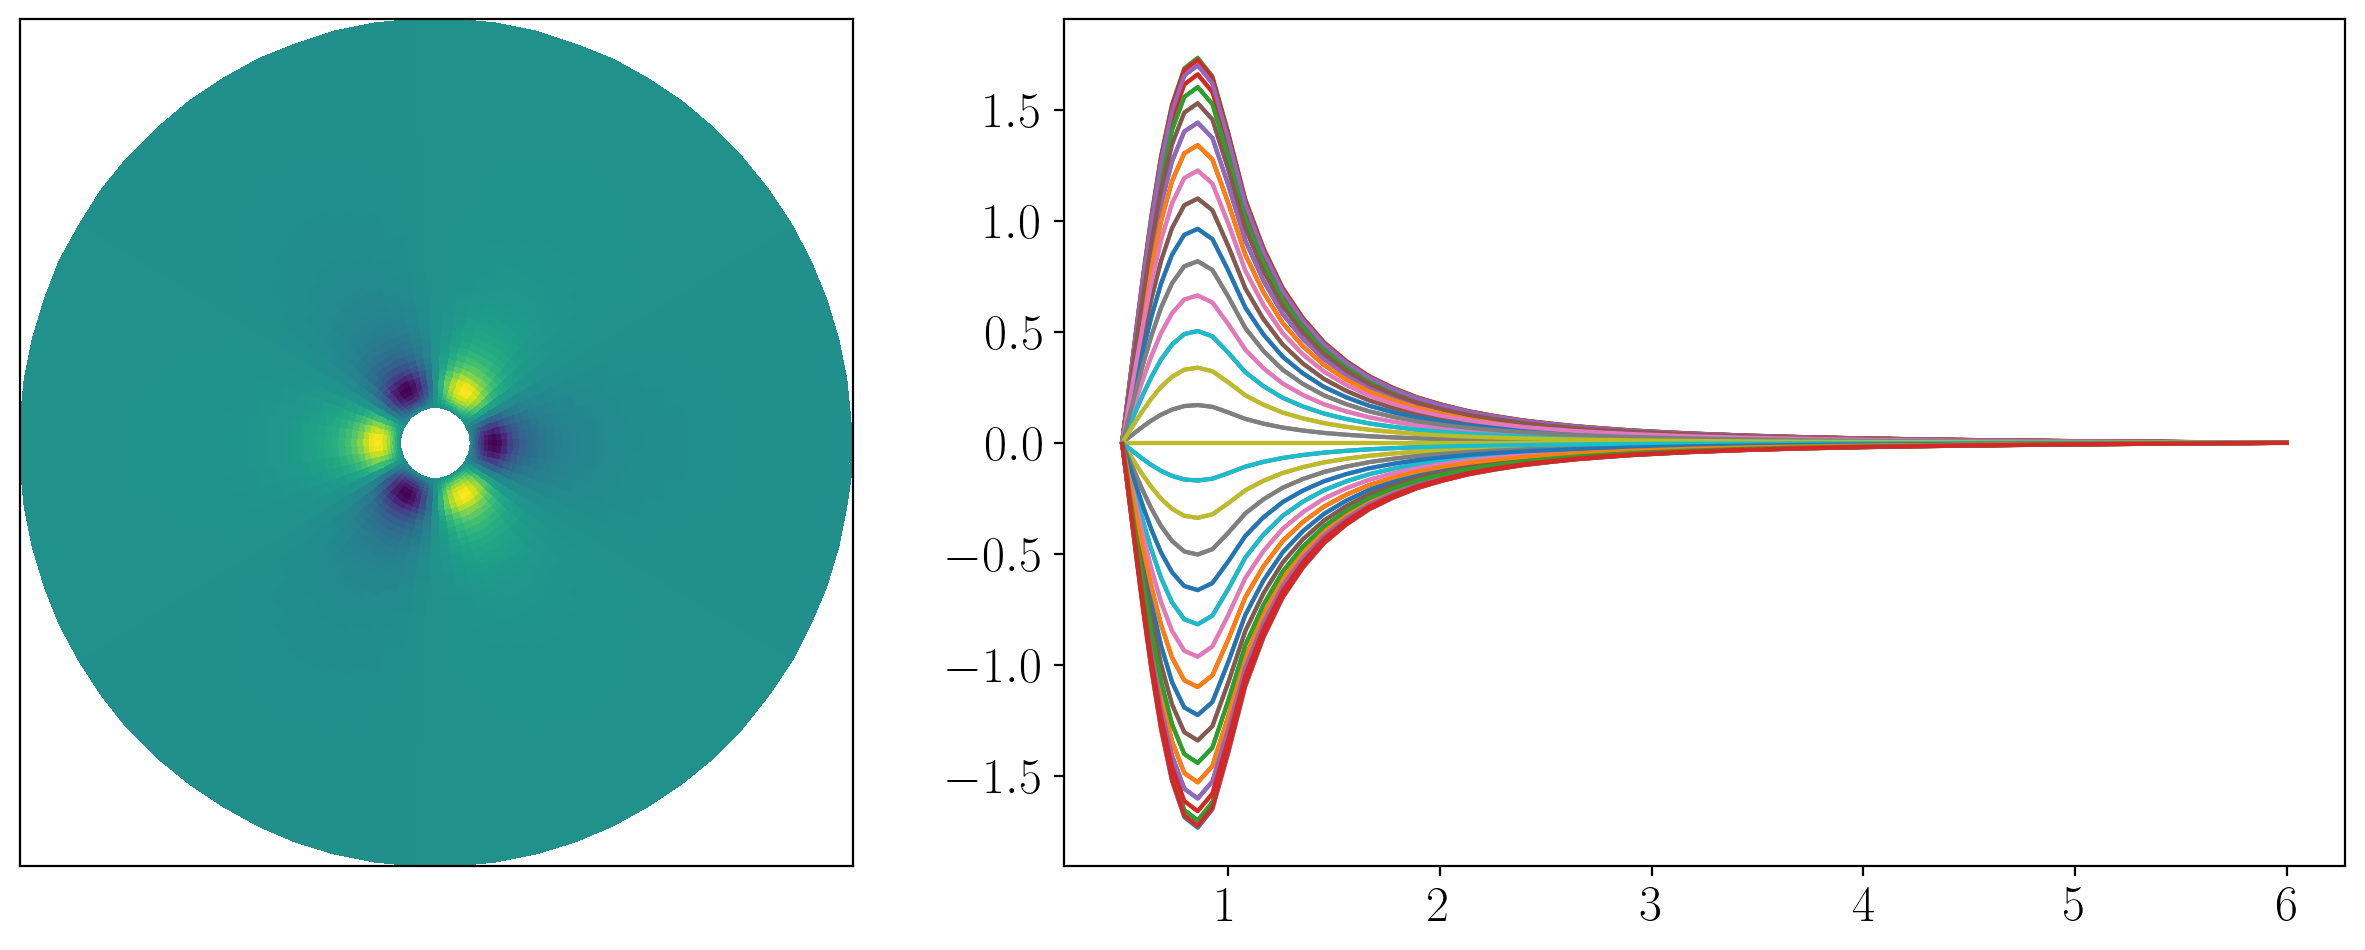

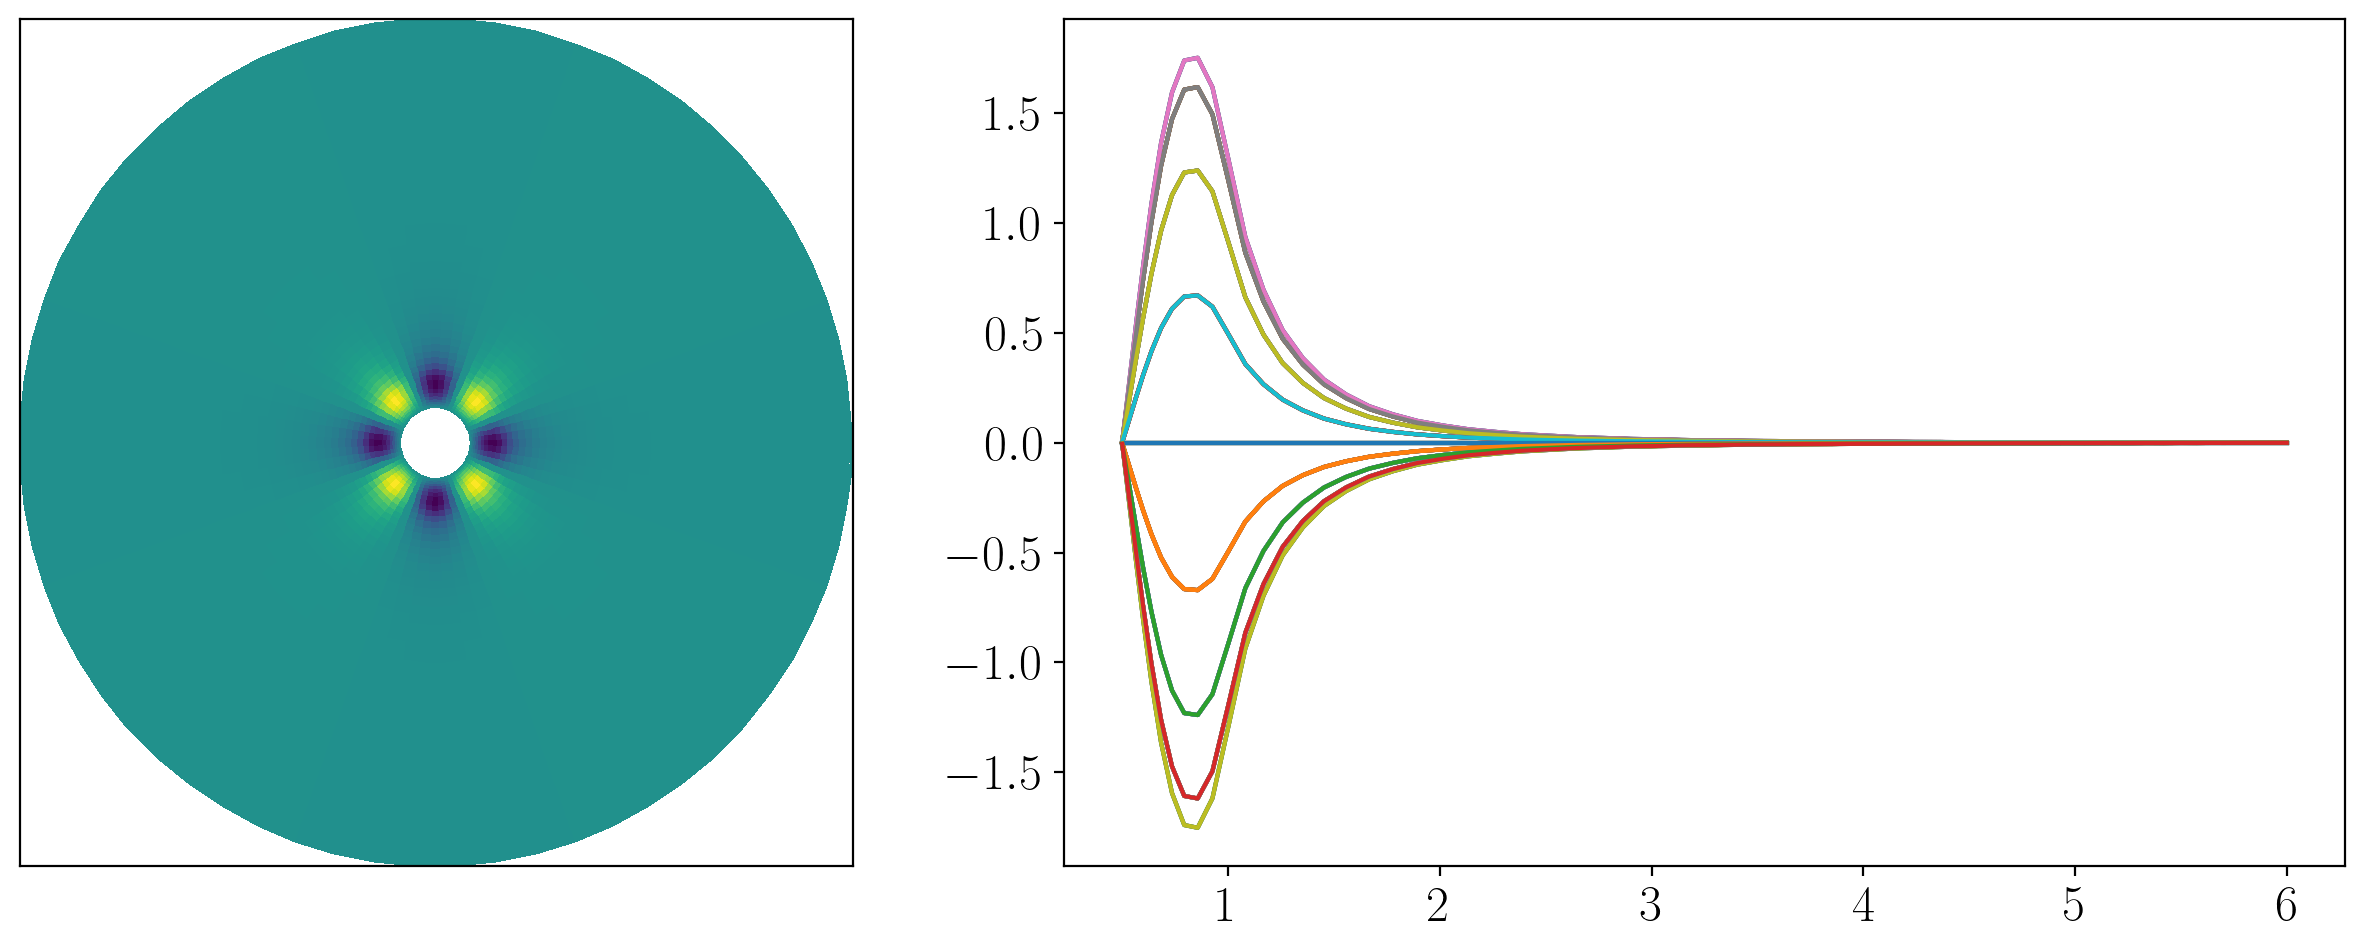

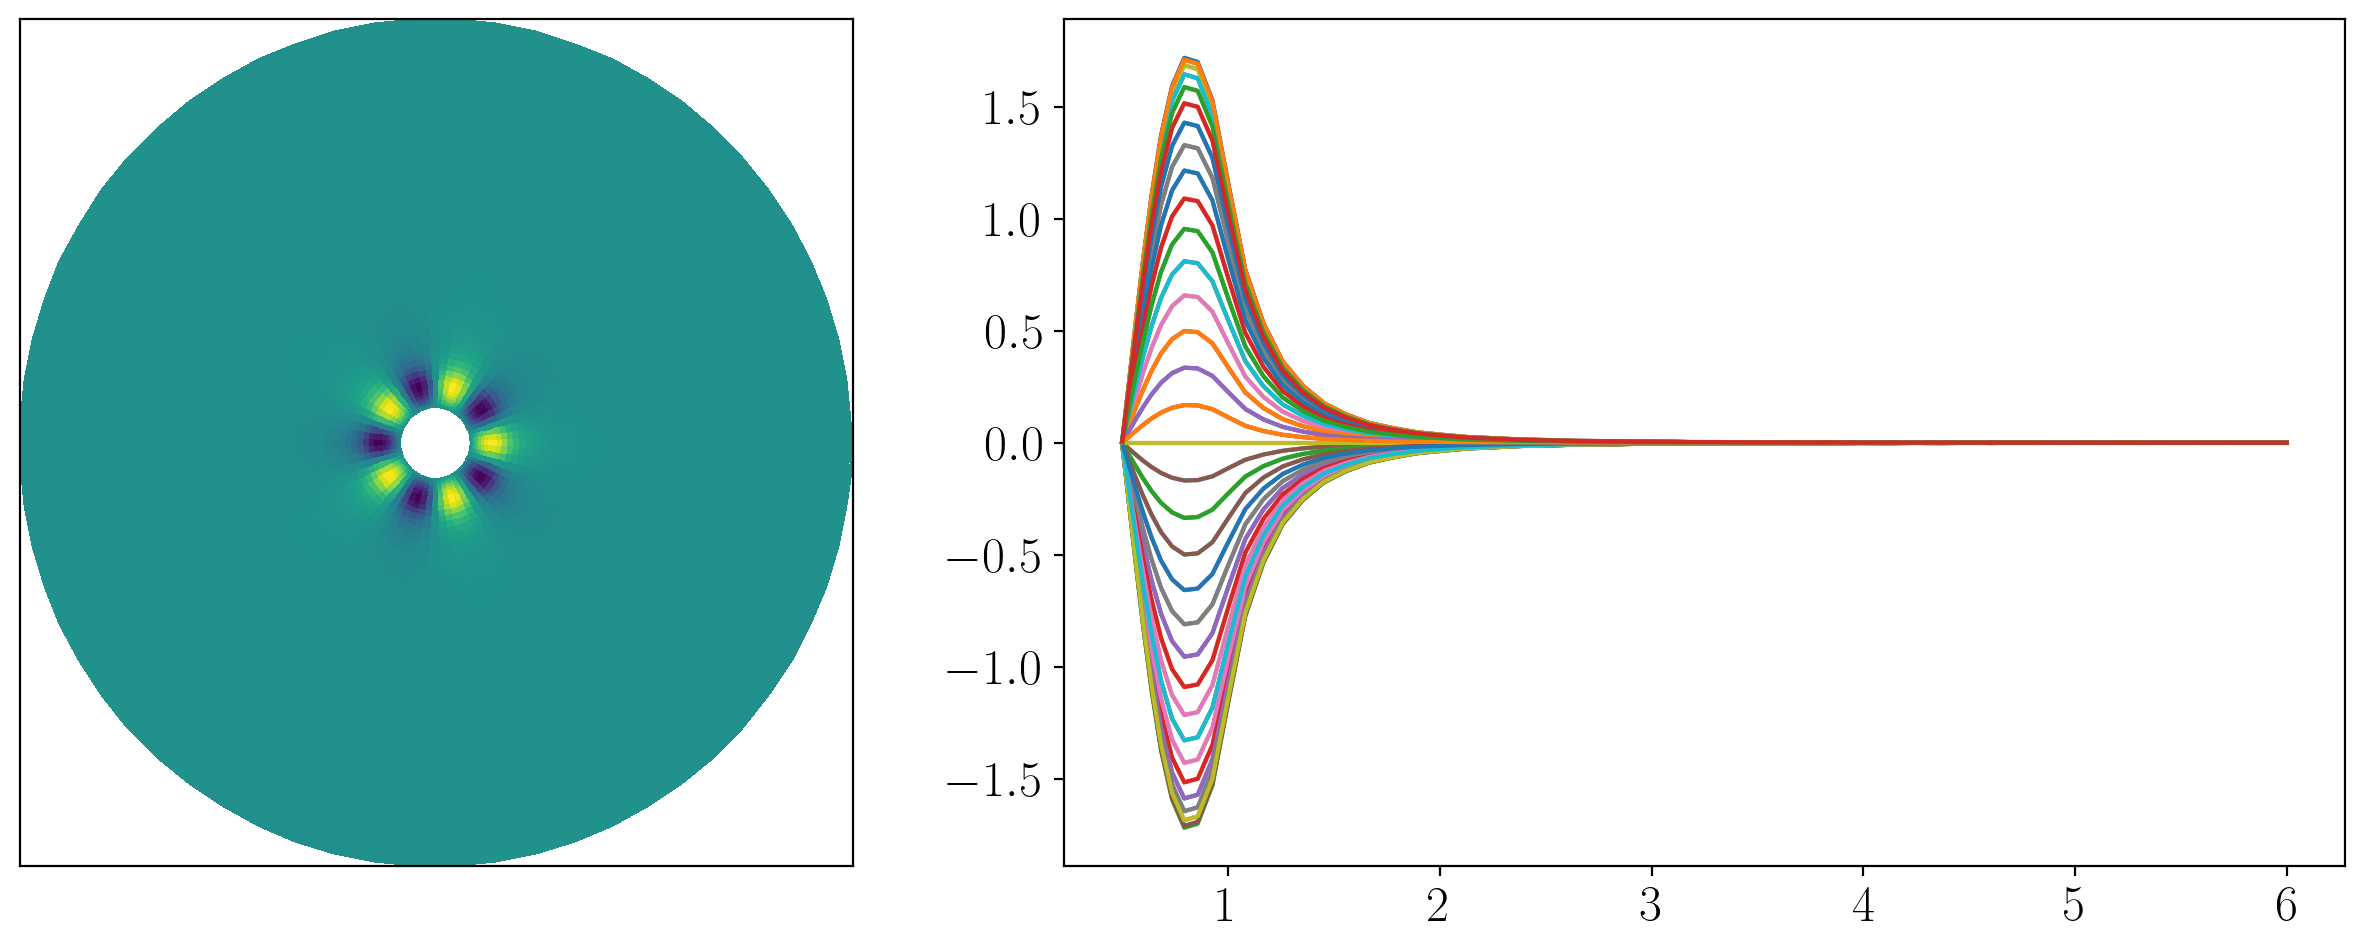

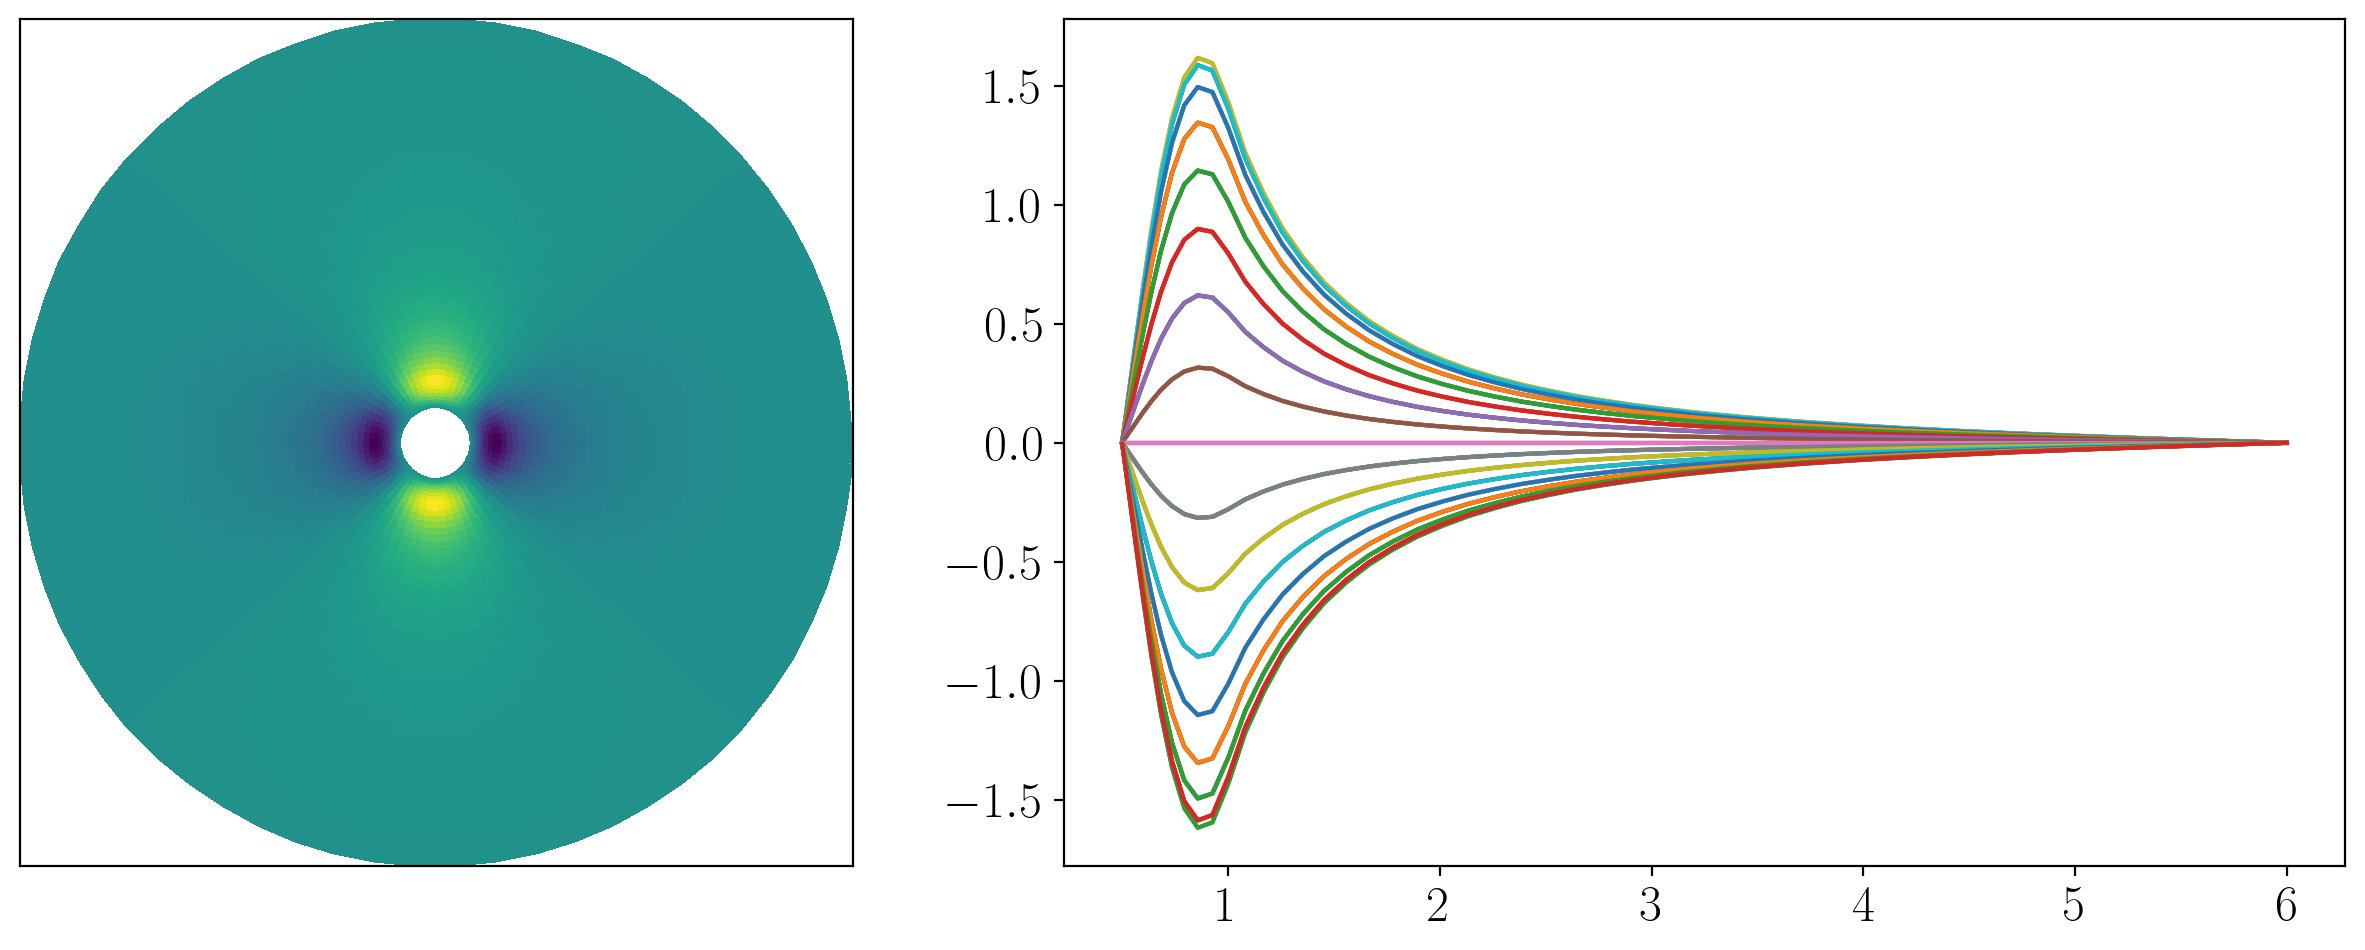

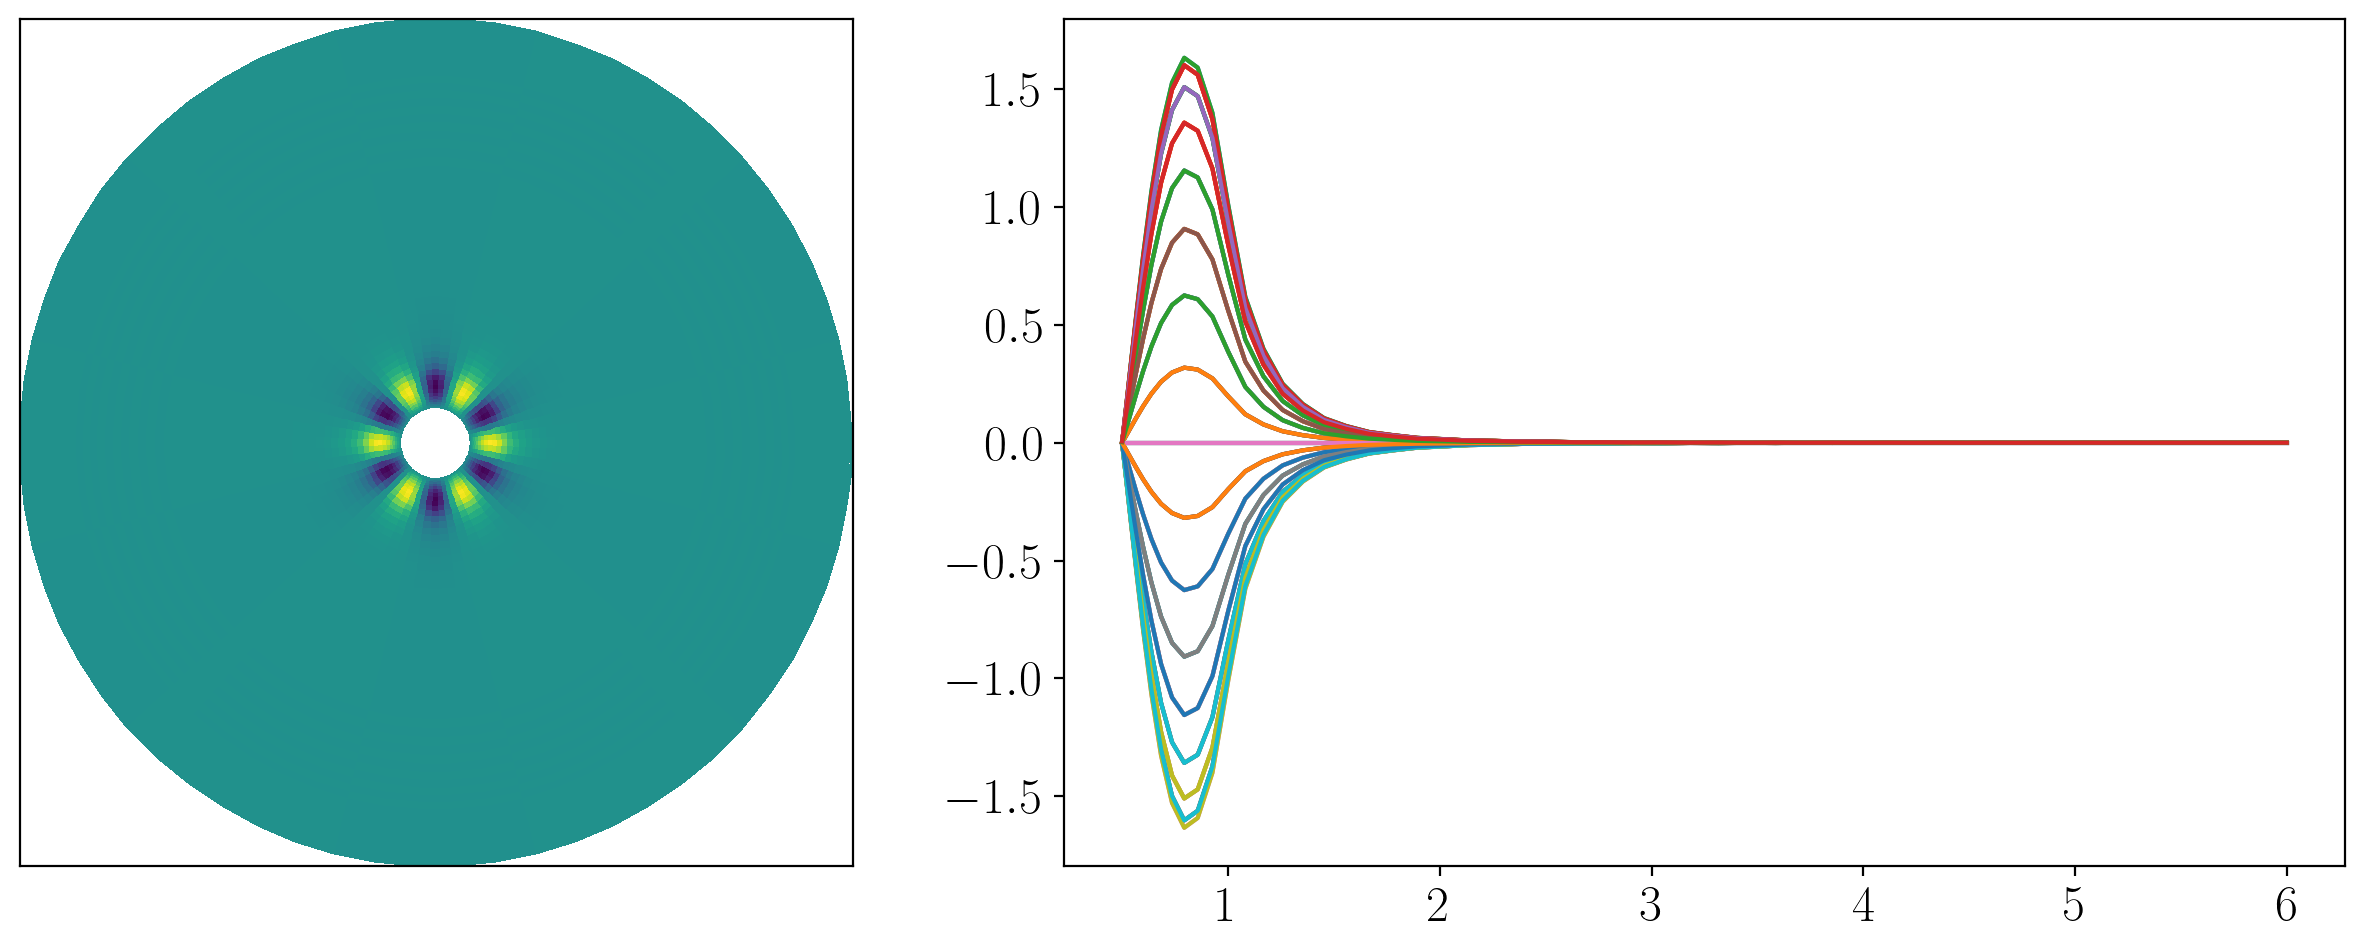

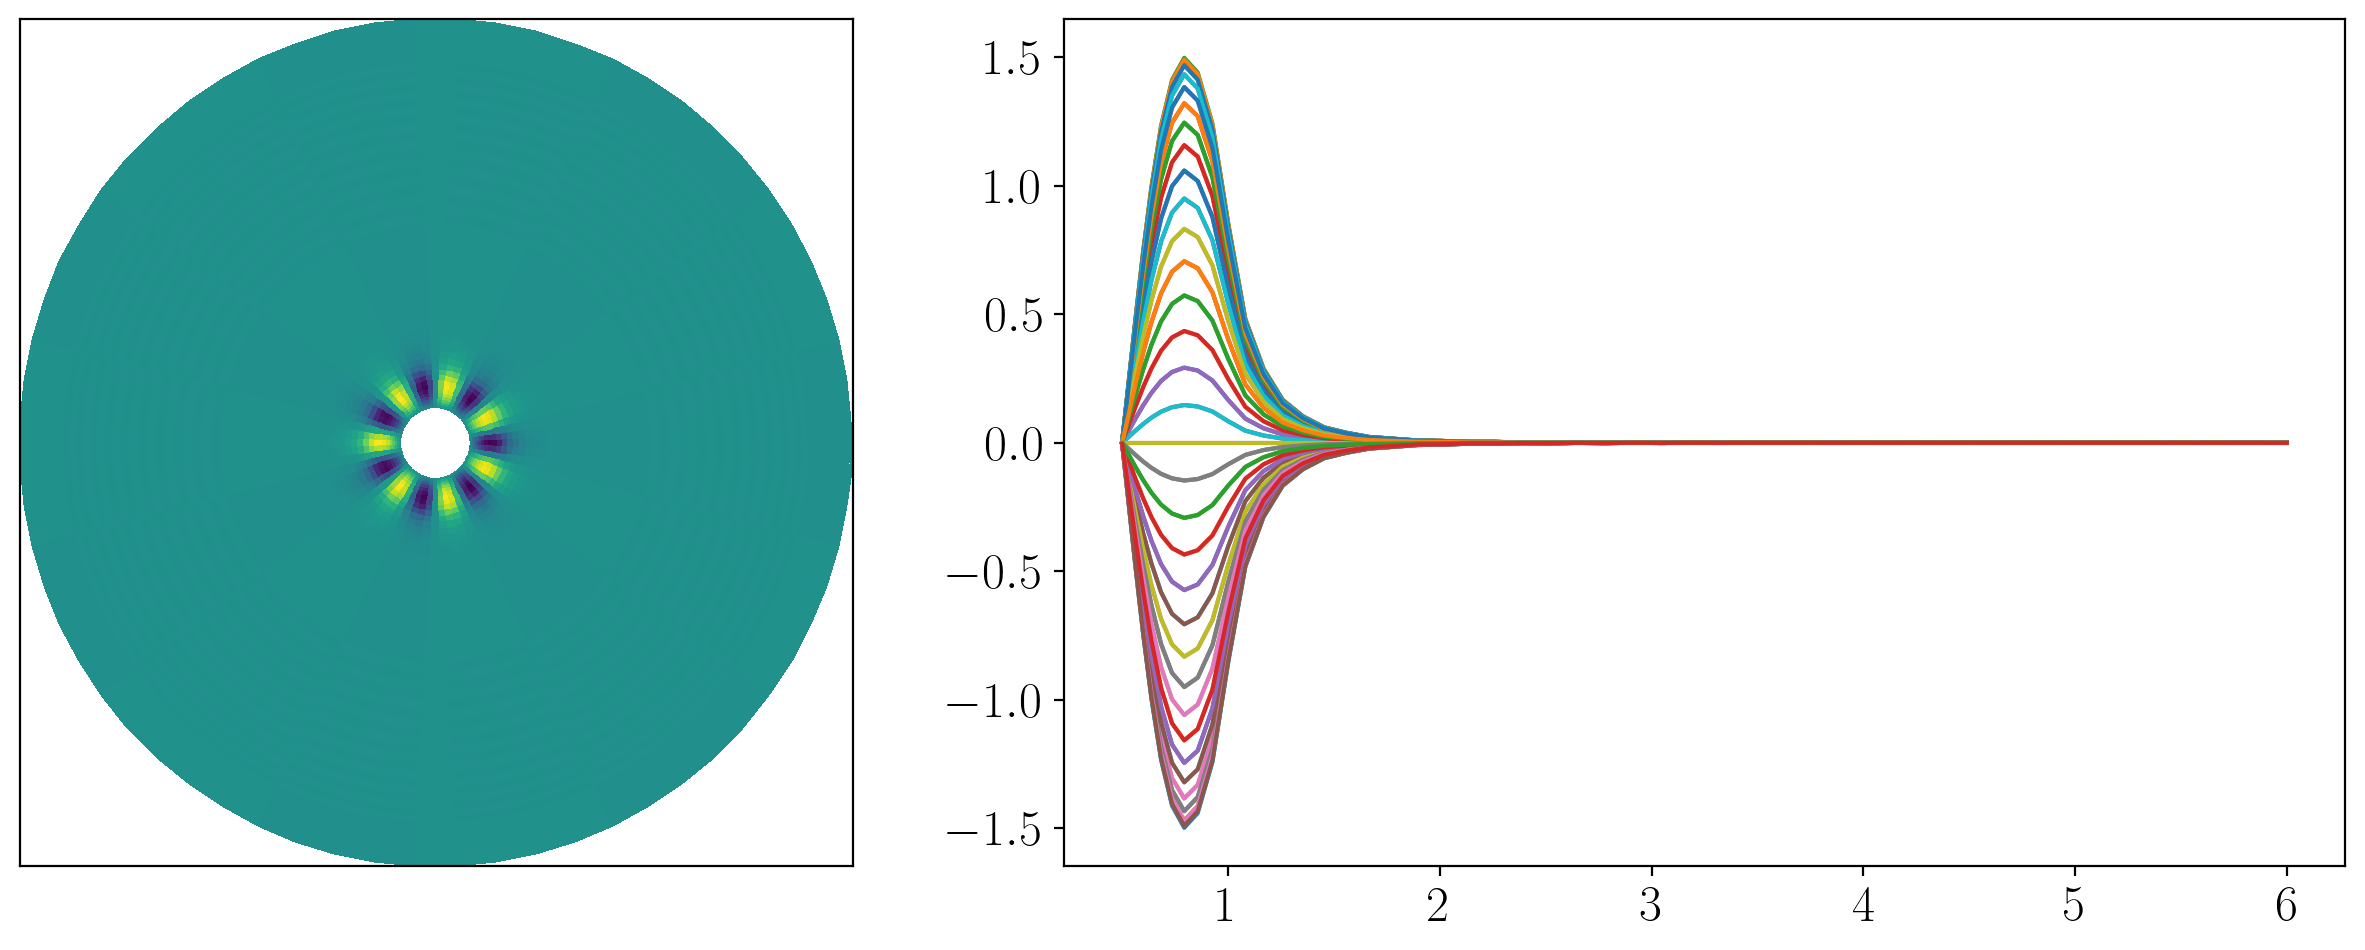

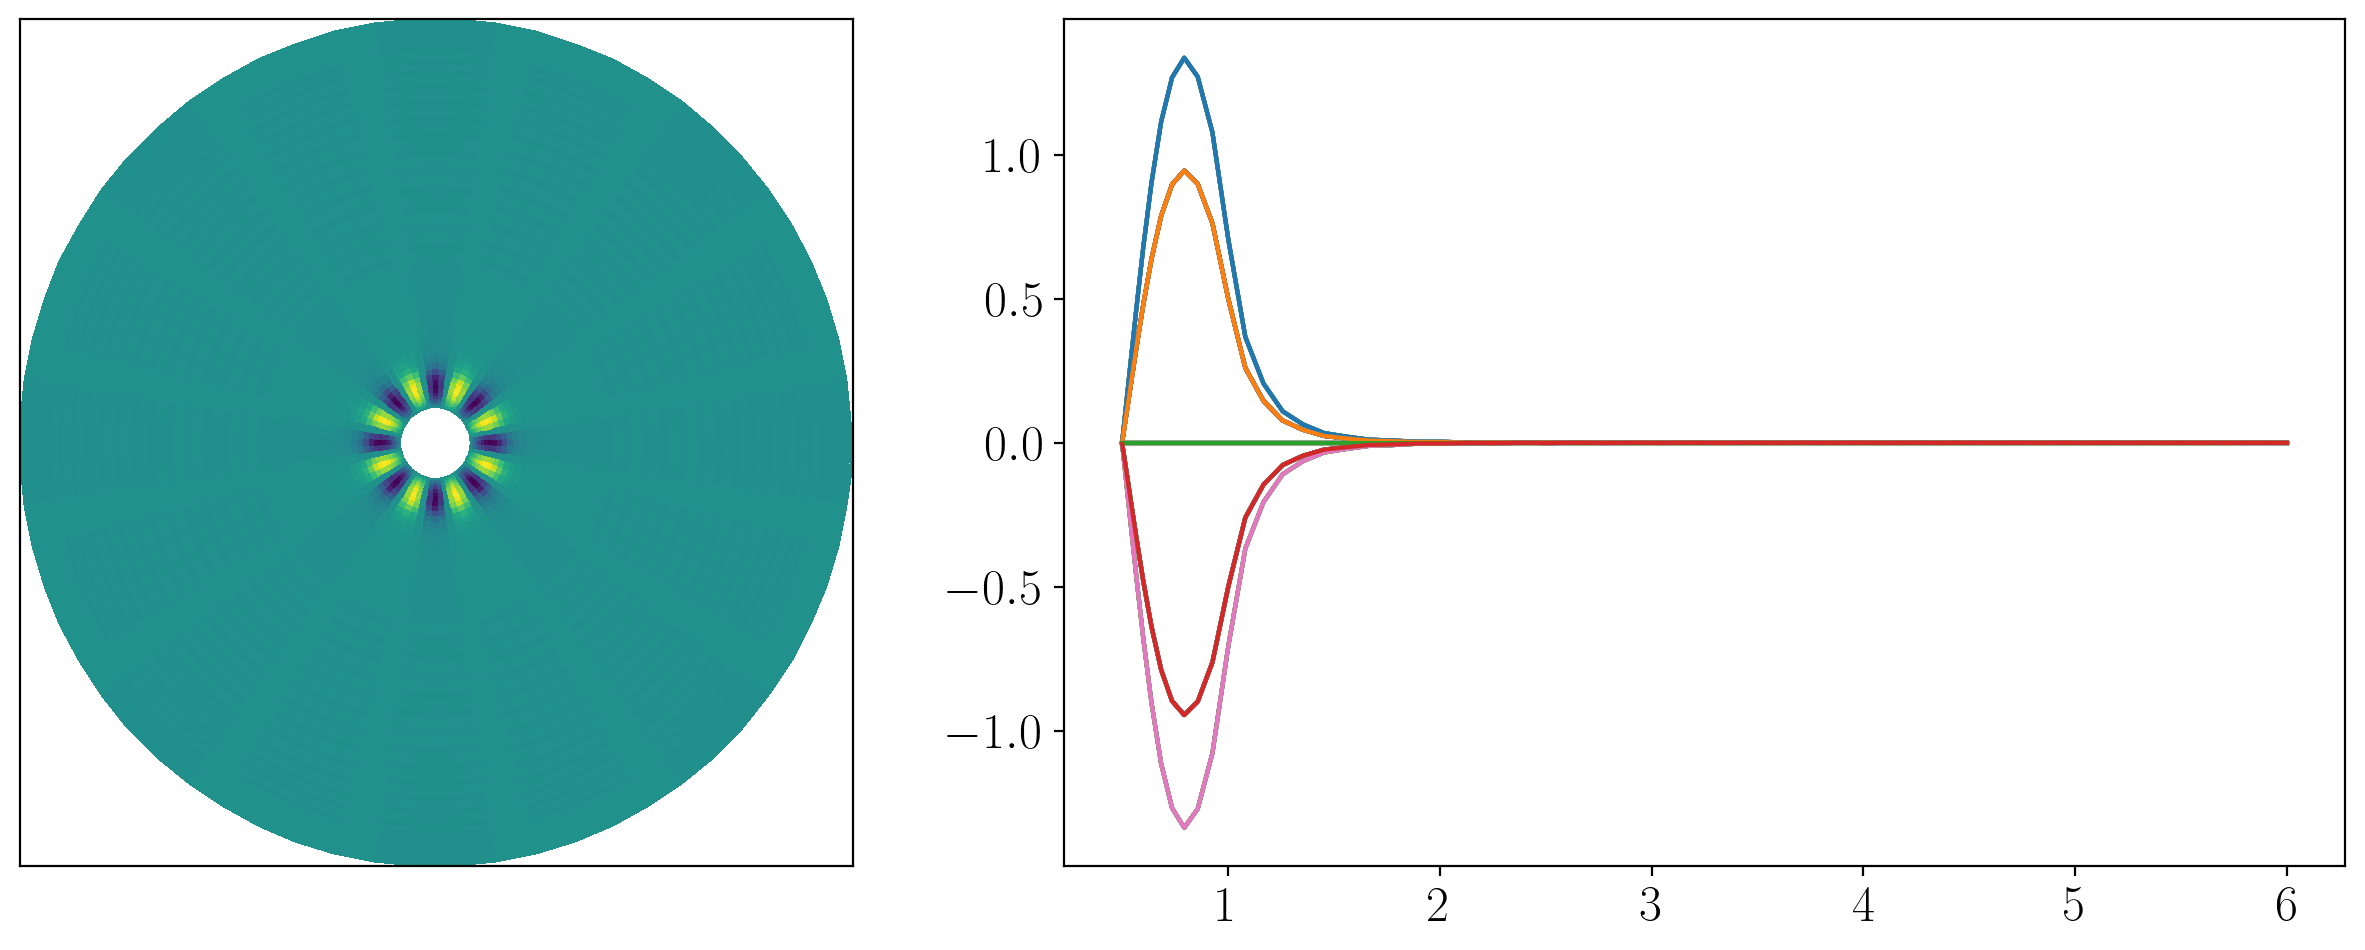

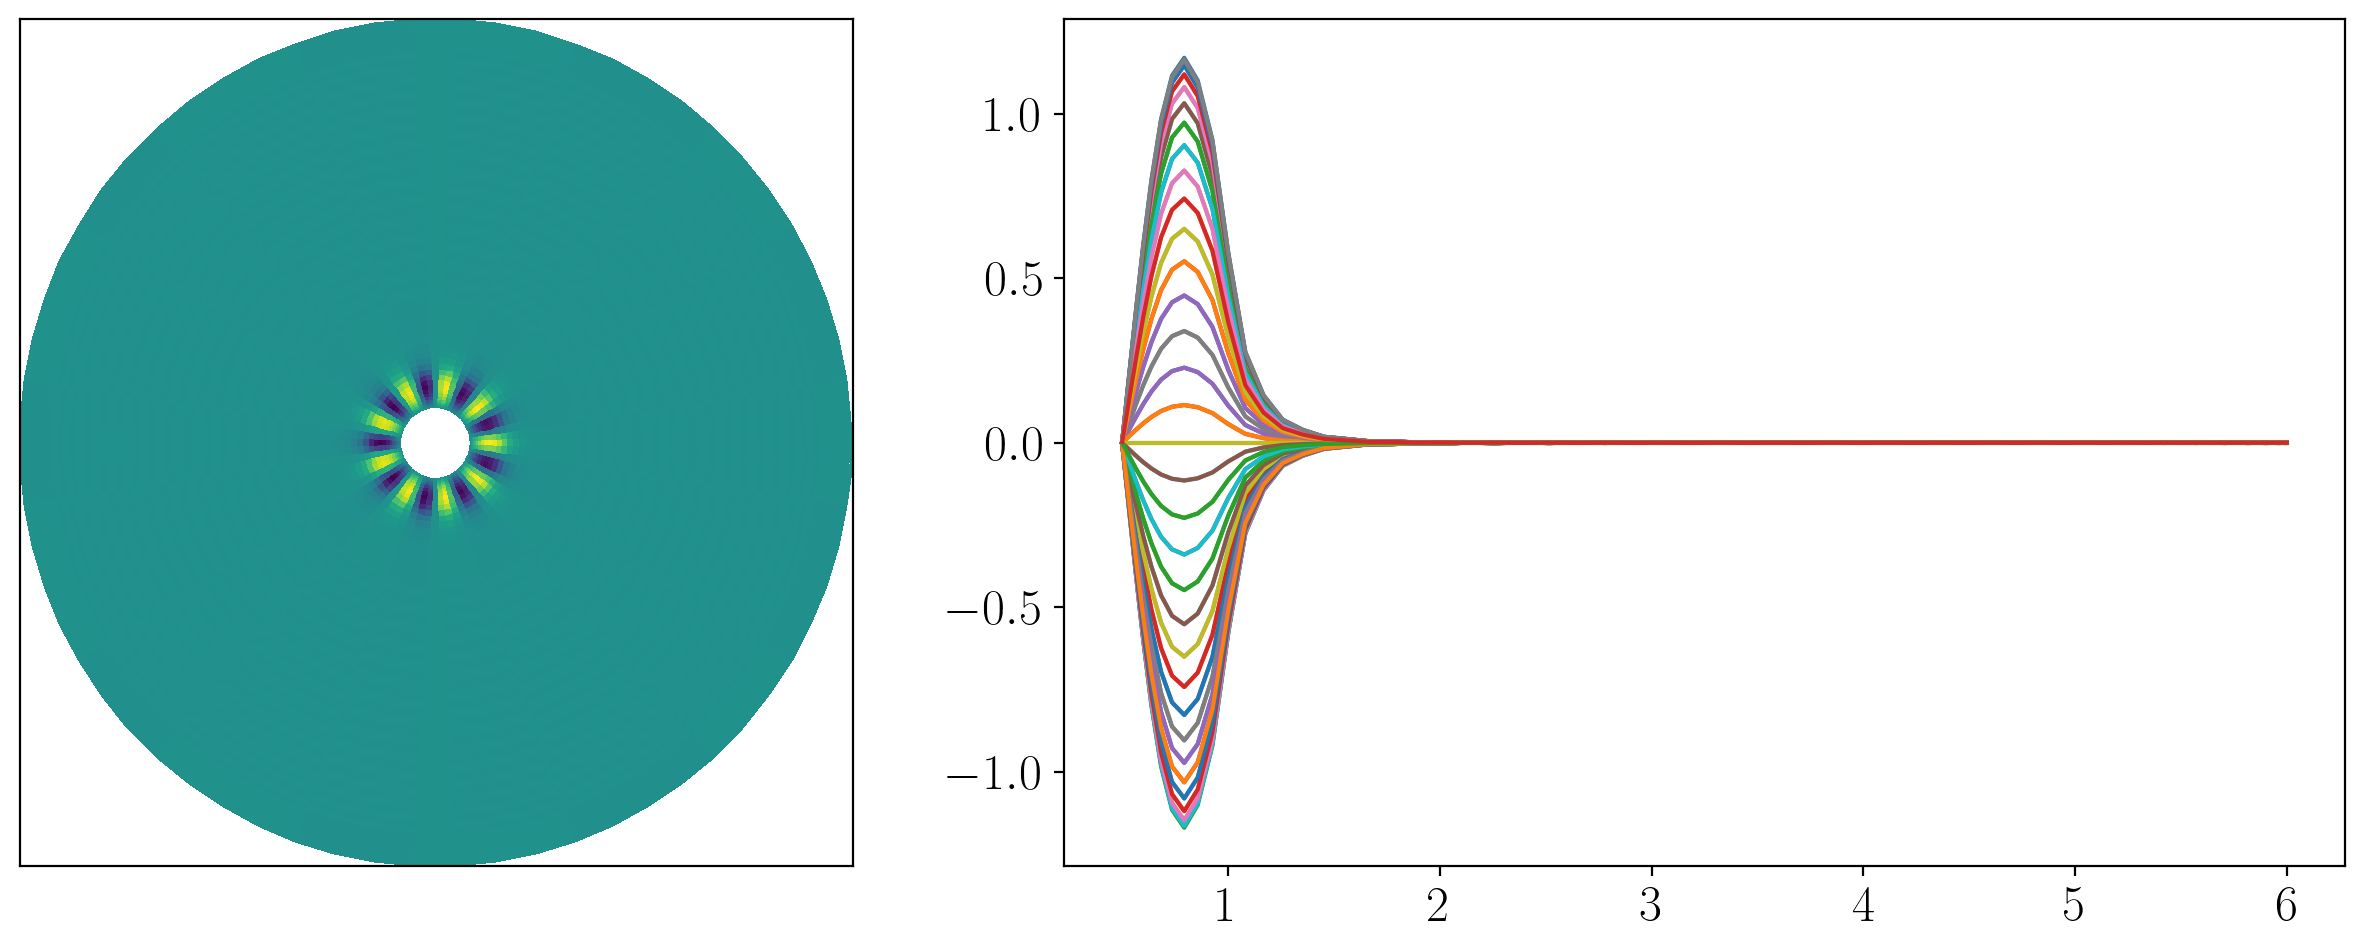

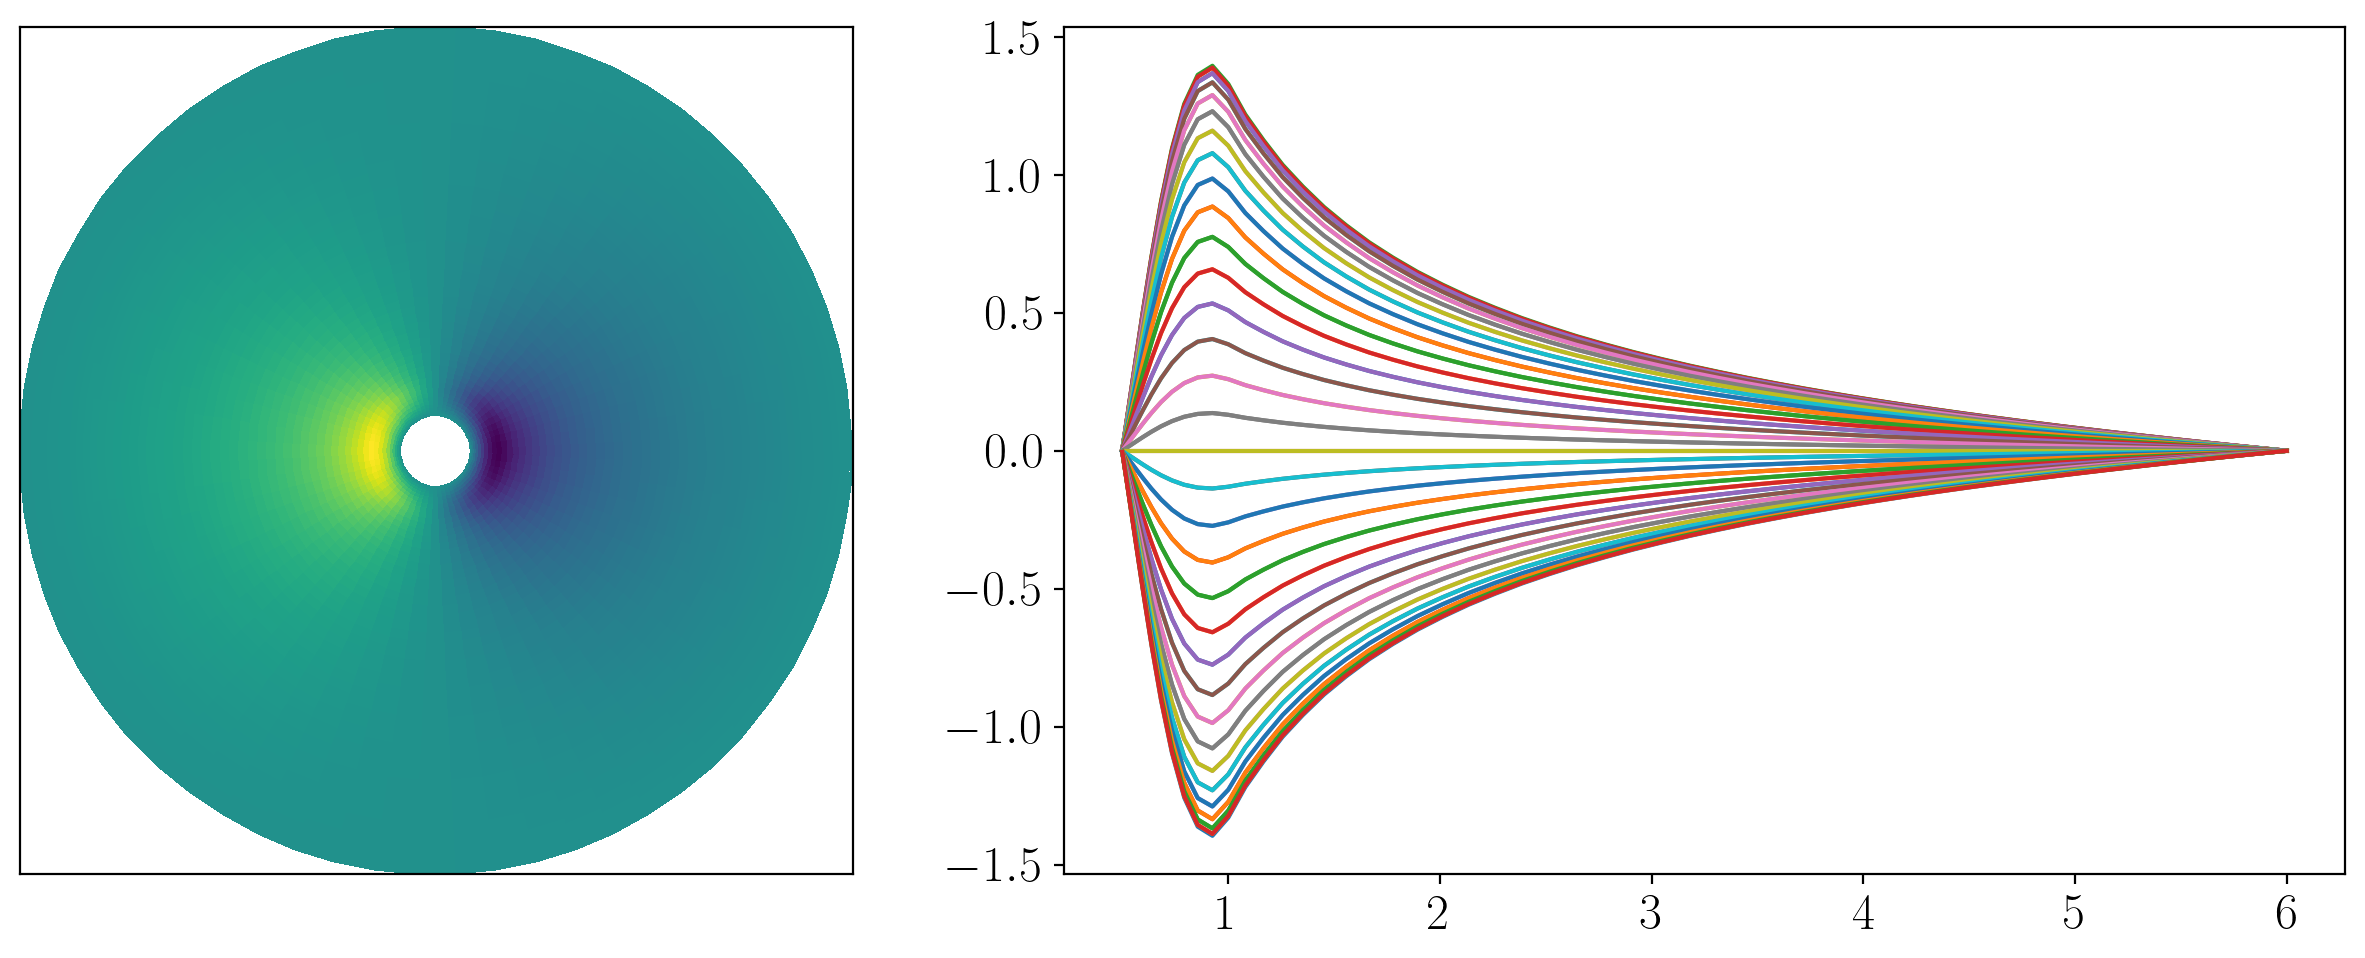

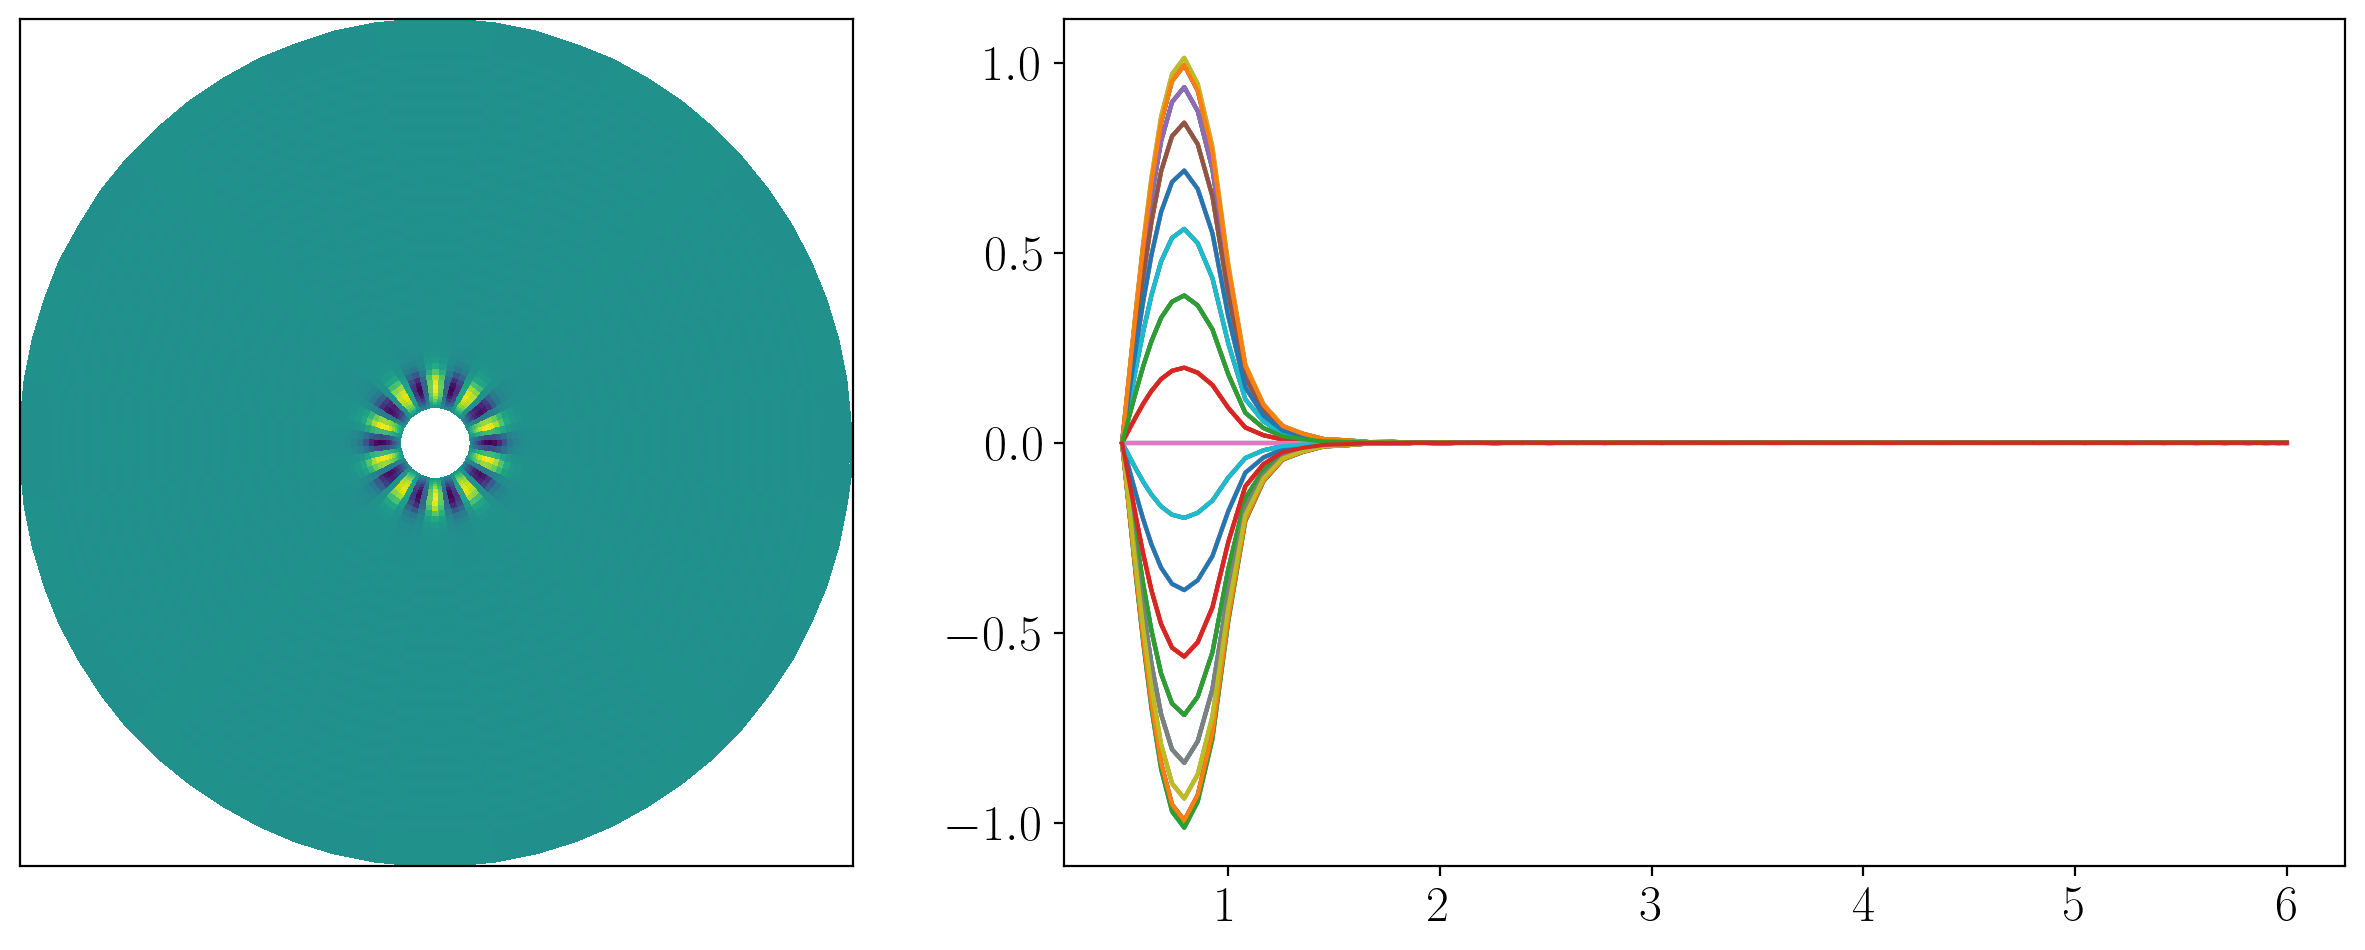

In [11]:
mode_order = np.argsort((np.real(1/solver_coupled.eigenvalues)))
eigs_order = np.abs(np.sort((np.real(1/solver_coupled.eigenvalues))))
### plot coupled system solution
R,THETA = np.meshgrid(r,θ)
x = R*np.cos(THETA); y=R*np.sin(THETA)

for i in mode_order[:10]:
    fig,(ax,ax1) = plt.subplots(1,2, figsize=(15,5.5),gridspec_kw={'width_ratios': [1.3,2]})
    solver_coupled.set_state(i, solver_coupled.subsystems[0])
    ax.pcolormesh(x,y,(Φ['g'].real))
    for j in range(Nθ):
        ax1.plot(np.squeeze(r),np.real(Φ['g'])[j,:])
    ax.set_xticks([]);ax.set_yticks([])
    plt.show()